# Caudal Horn Effect Size Analysis of BCs and F2s

##### *Date: Aug 2025*
##### *yk2840@columbia.edu*


This notebook contains the effect size analyses for BCs and F2s related to Supp Fig 5.

rQTL marker genotype data is available upon request. Corresponding author: pa2543@columbia.edu 


### Required Libraries

In [112]:
library(reshape2)
library(stats)
library(dplyr)
library(ggpubr)

### Calculate per-chromosome ancestries from chromosome-wide genotype proportions

In [113]:
setwd("/burg/palab/users/yk2840/workspace_Ana/Bombyx_data/MSG_analysis/F2_BC_combined_analysis_masked_nonfixed_genotypes")


In [114]:
BC_df<-read.csv("BC_whole_genome_thinned_concatenated_shared_markers_complete_genotypes.sorted.pulled.converted.thinned_ancestry_summary_per_chrom.csv")

# Convert BC genotypes to ancestries by accounting for both alleles
BC_df$B_ratio<-(BC_df$AB_Length+BC_df$BB_Length*2)/((BC_df$AB_Length*2)+(BC_df$AA_Length*2)+(BC_df$BB_Length*2))

# Import phenotype metadata
BC_pheno<-read.csv("./BC_pheno_corrected_length.csv")
BC_df<-cbind(BC_df, BC_pheno[match(BC_df$Individual, BC_pheno$id), c("sex", "length", "weight", "corr_len", "B_ancestry")])


# Correct for the fused Bmori chromosome-Chr14 and Chr27 (ie ChrM)
targets <- c("Chr14", "Chr27")

sums_by_individual <- BC_df %>%
  filter(Chromosome %in% targets) %>%
  group_by(Individual) %>%
  summarise(
    AA_Length = sum(AA_Length, na.rm = TRUE),
    AB_Length = sum(AB_Length, na.rm = TRUE),
    BB_Length = sum(BB_Length, na.rm = TRUE),
    .groups = "drop"
  )
BC_df$AA_Length[which(BC_df$Chromosome=="Chr14")]<-sums_by_individual$AA_Length[match(BC_df$Individual[which(BC_df$Chromosome=="Chr14")], sums_by_individual$Individual)]
BC_df$AB_Length[which(BC_df$Chromosome=="Chr14")]<-sums_by_individual$AB_Length[match(BC_df$Individual[which(BC_df$Chromosome=="Chr14")], sums_by_individual$Individual)]
BC_df$BB_Length[which(BC_df$Chromosome=="Chr14")]<-sums_by_individual$BB_Length[match(BC_df$Individual[which(BC_df$Chromosome=="Chr14")], sums_by_individual$Individual)]
BC_df<-BC_df[-which(BC_df$Chromosome=="Chr27"),]

head(BC_df)
head(BC_pheno)

,Individual,Chromosome,AA_Length,AB_Length,BB_Length,B_ratio,sex,length,weight,corr_len,B_ancestry
,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,indiv2002,Chr1,0,20564333,0,0.500000000,1,1.956674,1.19,2.115382,0.2758614
1.1,indiv2002,Chr10,16303172,1188762,0,0.033980291,1,1.956674,1.19,2.115382,0.2758614
1.2,indiv2002,Chr11,20103575,288443,0,0.007072449,1,1.956674,1.19,2.115382,0.2758614
1.3,indiv2002,Chr12,305475,17167913,0,0.491258850,1,1.956674,1.19,2.115382,0.2758614
1.4,indiv2002,Chr13,5398071,12126302,0,0.345983905,1,1.956674,1.19,2.115382,0.2758614
1.5,indiv2002,Chr14,13877700,9666413,0,0.219441054,1,1.956674,1.19,2.115382,0.2758614


,id,sex,length,weight,B_ancestry,corr_len
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,indiv2002,1,1.956674,1.19,0.2758614,2.115382
2,indiv2004,1,1.736989,1.26,0.2253809,1.867020
3,indiv2006,1,1.501522,1.46,0.3136184,1.549618
4,indiv2007,0,2.412518,1.72,0.3135697,2.283101
5,indiv2009,0,2.041476,1.84,0.2490812,1.862897
6,indiv2012,0,1.702795,1.48,0.3415559,1.671700


### Recalculate genome_wide ancestry excluding QTL chromosomes

In [115]:
# Remove QTL-bearing chromosomes
ancestry_subst<-BC_df[-which(BC_df$Chromosome %in% c("Chr4", "Chr5", "Chr7", "Chr9", "Chr10", "Chr21", "Chr25", "Chr26")),]

# Sum genotype intervals across all chromosomes
ancestry_summary <- ancestry_subst %>%
  group_by(Individual) %>%
  summarise(
    Total_AA = sum(AA_Length, na.rm = TRUE),
    Total_AB = sum(AB_Length, na.rm = TRUE),
    Total_BB = sum(BB_Length, na.rm = TRUE)
  )

# Account for both alleles in calculating Bmori and Bmand ancestries
ancestry_summary$Total<-ancestry_summary$Total_AA*2 + ancestry_summary$Total_AB * 2 + ancestry_summary$Total_BB * 2 
ancestry_summary$Prop_A<-(ancestry_summary$Total_AA*2 + ancestry_summary$Total_AB )/ancestry_summary$Total
ancestry_summary$Prop_B<-(ancestry_summary$Total_BB*2 + ancestry_summary$Total_AB )/ancestry_summary$Total


ancestry_summary$Prop_BB<-(ancestry_summary$Total_BB)/(ancestry_summary$Total_AA+ancestry_summary$Total_AB+ancestry_summary$Total_BB)
ancestry_summary$Prop_AA<-(ancestry_summary$Total_AA)/(ancestry_summary$Total_AA+ancestry_summary$Total_AB+ancestry_summary$Total_BB)

BC_df$B_ancestry_nonQTL<-ancestry_summary$Prop_B[match(BC_df$Individual, ancestry_summary$Individual)]
BC_pheno$B_ancestry_nonQTL<-ancestry_summary$Prop_B[match(BC_pheno$id, ancestry_summary$Individual)] # Add this information to the metadata for BC


head(BC_df)

,Individual,Chromosome,AA_Length,AB_Length,BB_Length,B_ratio,sex,length,weight,corr_len,B_ancestry,B_ancestry_nonQTL
,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,indiv2002,Chr1,0,20564333,0,0.500000000,1,1.956674,1.19,2.115382,0.2758614,0.2758614
1.1,indiv2002,Chr10,16303172,1188762,0,0.033980291,1,1.956674,1.19,2.115382,0.2758614,0.2758614
1.2,indiv2002,Chr11,20103575,288443,0,0.007072449,1,1.956674,1.19,2.115382,0.2758614,0.2758614
1.3,indiv2002,Chr12,305475,17167913,0,0.491258850,1,1.956674,1.19,2.115382,0.2758614,0.2758614
1.4,indiv2002,Chr13,5398071,12126302,0,0.345983905,1,1.956674,1.19,2.115382,0.2758614,0.2758614
1.5,indiv2002,Chr14,13877700,9666413,0,0.219441054,1,1.956674,1.19,2.115382,0.2758614,0.2758614


In [116]:
ancestry_subst<-BC_df
ancestry_summary <- ancestry_subst %>%
  group_by(Individual) %>%
  summarise(
    Total_AA = sum(AA_Length, na.rm = TRUE),
    Total_AB = sum(AB_Length, na.rm = TRUE),
    Total_BB = sum(BB_Length, na.rm = TRUE)
  )
ancestry_summary$Total<-ancestry_summary$Total_AA*2 + ancestry_summary$Total_AB * 2 + ancestry_summary$Total_BB * 2 
ancestry_summary$Prop_A<-(ancestry_summary$Total_AA*2 + ancestry_summary$Total_AB )/ancestry_summary$Total
ancestry_summary$Prop_B<-(ancestry_summary$Total_BB*2 + ancestry_summary$Total_AB )/ancestry_summary$Total


ancestry_summary$Prop_BB<-(ancestry_summary$Total_BB)/(ancestry_summary$Total_AA+ancestry_summary$Total_AB+ancestry_summary$Total_BB)
ancestry_summary$Prop_AA<-(ancestry_summary$Total_AA)/(ancestry_summary$Total_AA+ancestry_summary$Total_AB+ancestry_summary$Total_BB)

BC_df$B_ancestry_allchrom<-ancestry_summary$Prop_B[match(BC_df$Individual, ancestry_summary$Individual)]

BC_pheno$B_ancestry_allchrom<-ancestry_summary$Prop_B[match(BC_pheno$id, ancestry_summary$Individual)] # Add this information to the metadata for BC


head(BC_pheno)

,id,sex,length,weight,B_ancestry,corr_len,B_ancestry_nonQTL,B_ancestry_allchrom
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,indiv2002,1,1.956674,1.19,0.2758614,2.115382,0.2758614,0.2916324
2,indiv2004,1,1.736989,1.26,0.2253809,1.867020,0.2253809,0.2257519
3,indiv2006,1,1.501522,1.46,0.3136184,1.549618,0.3136184,0.3030192
4,indiv2007,0,2.412518,1.72,0.3135697,2.283101,0.3135697,0.2983140
5,indiv2009,0,2.041476,1.84,0.2490812,1.862897,0.2490812,0.2598232
6,indiv2012,0,1.702795,1.48,0.3415559,1.671700,0.3415559,0.3171689


#### Repeat the same process for the F2s

In [117]:
# Import per-chromosome genotype intervals for F2 individuals
F2_df<-read.csv("F2_whole_genome_thinned_concatenated_shared_markers_complete_genotypes.sorted.pulled.converted.thinned_ancestry_summary_per_chrom.csv")
F2_df$B_ratio<-with(F2_df, (AB_Length+BB_Length*2)/((AB_Length*2)+(AA_Length*2)+(BB_Length*2)))

# Import F2 metadata
F2_pheno<-read.csv("./F2_pheno_corrected_length.csv")
F2_df<-cbind(F2_df, F2_pheno[match(F2_df$Individual, F2_pheno$id), c("sex", "length", "weight", "corr_len", "B_ancestry")])


# Fuse Chr14 and Chr27
targets <- c("Chr14", "Chr27")

sums_by_individual <- F2_df %>%
  filter(Chromosome %in% targets) %>%
  group_by(Individual) %>%
  summarise(
    AA_Length = sum(AA_Length, na.rm = TRUE),
    AB_Length = sum(AB_Length, na.rm = TRUE),
    BB_Length = sum(BB_Length, na.rm = TRUE),
    .groups = "drop"
  )
F2_df$AA_Length[which(F2_df$Chromosome=="Chr14")]<-sums_by_individual$AA_Length[match(F2_df$Individual[which(F2_df$Chromosome=="Chr14")], sums_by_individual$Individual)]
F2_df$AB_Length[which(F2_df$Chromosome=="Chr14")]<-sums_by_individual$AB_Length[match(F2_df$Individual[which(F2_df$Chromosome=="Chr14")], sums_by_individual$Individual)]
F2_df$BB_Length[which(F2_df$Chromosome=="Chr14")]<-sums_by_individual$BB_Length[match(F2_df$Individual[which(F2_df$Chromosome=="Chr14")], sums_by_individual$Individual)]
F2_df<-F2_df[-which(F2_df$Chromosome=="Chr27"),]



head(F2_df)

,Individual,Chromosome,AA_Length,AB_Length,BB_Length,B_ratio,sex,length,weight,corr_len,B_ancestry
,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,indiv4047,Chr1,3666265,0,16307420,0.8164452,0,1.394069,1.2,1.420696,0.4393733
1.1,indiv4047,Chr10,15905891,0,0,0.0000000,0,1.394069,1.2,1.420696,0.4393733
1.2,indiv4047,Chr11,288443,12038298,8065277,0.6906833,0,1.394069,1.2,1.420696,0.4393733
1.3,indiv4047,Chr12,0,2836395,14637075,0.9188371,0,1.394069,1.2,1.420696,0.4393733
1.4,indiv4047,Chr13,0,17613084,0,0.5000000,0,1.394069,1.2,1.420696,0.4393733
1.5,indiv4047,Chr14,172817,24001657,0,0.5000000,0,1.394069,1.2,1.420696,0.4393733


In [118]:
# Remove QTL-bearing chromosomes
ancestry_subst<-F2_df[-which(F2_df$Chromosome %in% 
                             c("Chr1", "Chr3", "Chr8", "Chr18",
                                 "Chr4", "Chr5", "Chr7", "Chr9", "Chr10", "Chr21", "Chr25", "Chr26")),]

# Sum genotype intervals across all chromosomes
ancestry_summary <- ancestry_subst %>%
  group_by(Individual) %>%
  summarise(
    Total_AA = sum(AA_Length, na.rm = TRUE),
    Total_AB = sum(AB_Length, na.rm = TRUE),
    Total_BB = sum(BB_Length, na.rm = TRUE)
  )

# Account for both alleles in calculating Bmori and Bmand ancestries
ancestry_summary$Total<-ancestry_summary$Total_AA*2 + ancestry_summary$Total_AB * 2 + ancestry_summary$Total_BB * 2 
ancestry_summary$Prop_A<-(ancestry_summary$Total_AA*2 + ancestry_summary$Total_AB )/ancestry_summary$Total
ancestry_summary$Prop_B<-(ancestry_summary$Total_BB*2 + ancestry_summary$Total_AB )/ancestry_summary$Total


ancestry_summary$Prop_BB<-(ancestry_summary$Total_BB)/(ancestry_summary$Total_AA+ancestry_summary$Total_AB+ancestry_summary$Total_BB)
ancestry_summary$Prop_AA<-(ancestry_summary$Total_AA)/(ancestry_summary$Total_AA+ancestry_summary$Total_AB+ancestry_summary$Total_BB)

F2_df$B_ancestry_nonQTL<-ancestry_summary$Prop_B[match(F2_df$Individual, ancestry_summary$Individual)]
F2_pheno$B_ancestry_nonQTL<-ancestry_summary$Prop_B[match(F2_pheno$id, ancestry_summary$Individual)]

head(F2_df)

,Individual,Chromosome,AA_Length,AB_Length,BB_Length,B_ratio,sex,length,weight,corr_len,B_ancestry,B_ancestry_nonQTL
,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,indiv4047,Chr1,3666265,0,16307420,0.8164452,0,1.394069,1.2,1.420696,0.4393733,0.4881682
1.1,indiv4047,Chr10,15905891,0,0,0.0000000,0,1.394069,1.2,1.420696,0.4393733,0.4881682
1.2,indiv4047,Chr11,288443,12038298,8065277,0.6906833,0,1.394069,1.2,1.420696,0.4393733,0.4881682
1.3,indiv4047,Chr12,0,2836395,14637075,0.9188371,0,1.394069,1.2,1.420696,0.4393733,0.4881682
1.4,indiv4047,Chr13,0,17613084,0,0.5000000,0,1.394069,1.2,1.420696,0.4393733,0.4881682
1.5,indiv4047,Chr14,172817,24001657,0,0.5000000,0,1.394069,1.2,1.420696,0.4393733,0.4881682


In [119]:
ancestry_subst<-F2_df
ancestry_summary <- ancestry_subst %>%
  group_by(Individual) %>%
  summarise(
    Total_AA = sum(AA_Length, na.rm = TRUE),
    Total_AB = sum(AB_Length, na.rm = TRUE),
    Total_BB = sum(BB_Length, na.rm = TRUE)
  )
ancestry_summary$Total<-ancestry_summary$Total_AA*2 + ancestry_summary$Total_AB * 2 + ancestry_summary$Total_BB * 2 
ancestry_summary$Prop_A<-(ancestry_summary$Total_AA*2 + ancestry_summary$Total_AB )/ancestry_summary$Total
ancestry_summary$Prop_B<-(ancestry_summary$Total_BB*2 + ancestry_summary$Total_AB )/ancestry_summary$Total


ancestry_summary$Prop_BB<-(ancestry_summary$Total_BB)/(ancestry_summary$Total_AA+ancestry_summary$Total_AB+ancestry_summary$Total_BB)
ancestry_summary$Prop_AA<-(ancestry_summary$Total_AA)/(ancestry_summary$Total_AA+ancestry_summary$Total_AB+ancestry_summary$Total_BB)

F2_df$B_ancestry_allchrom<-ancestry_summary$Prop_B[match(F2_df$Individual, ancestry_summary$Individual)]

F2_pheno$B_ancestry_allchrom<-ancestry_summary$Prop_B[match(F2_pheno$id, ancestry_summary$Individual)]


head(F2_df)
head(F2_pheno)

,Individual,Chromosome,AA_Length,AB_Length,BB_Length,B_ratio,sex,length,weight,corr_len,B_ancestry,B_ancestry_nonQTL,B_ancestry_allchrom
,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,indiv4047,Chr1,3666265,0,16307420,0.8164452,0,1.394069,1.2,1.420696,0.4393733,0.4881682,0.402401
1.1,indiv4047,Chr10,15905891,0,0,0.0000000,0,1.394069,1.2,1.420696,0.4393733,0.4881682,0.402401
1.2,indiv4047,Chr11,288443,12038298,8065277,0.6906833,0,1.394069,1.2,1.420696,0.4393733,0.4881682,0.402401
1.3,indiv4047,Chr12,0,2836395,14637075,0.9188371,0,1.394069,1.2,1.420696,0.4393733,0.4881682,0.402401
1.4,indiv4047,Chr13,0,17613084,0,0.5000000,0,1.394069,1.2,1.420696,0.4393733,0.4881682,0.402401
1.5,indiv4047,Chr14,172817,24001657,0,0.5000000,0,1.394069,1.2,1.420696,0.4393733,0.4881682,0.402401


,id,sex,length,weight,B_ancestry,corr_len,B_ancestry_nonQTL,B_ancestry_allchrom
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,indiv4047,0,1.394069,1.20,0.4393733,1.420696,0.4881682,0.4024010
2,indiv4071,0,1.809799,1.24,0.4793393,1.829262,0.4626961,0.4840026
3,indiv4095,0,1.874248,1.20,0.4951696,1.900875,0.4874715,0.5488138
4,indiv4117,0,1.431828,1.26,0.4486405,1.447710,0.3906883,0.4523978
5,indiv4118,0,1.730434,1.45,0.4149031,1.712285,0.4323387,0.4164387
6,indiv4119,0,1.964063,1.37,0.4501663,1.960243,0.3904014,0.4671397


### Import 1D scan LOD profile for Length

In [120]:
QTL_df<-read.csv("BC_LOD_top_length.csv")
QTL_df$chr<-paste0("Chr",QTL_df$chr)
head(QTL_df)

,lod.chr,lod.pos,lod.ci.low,lod.ci.high,lod.lod,chr,pos,lod
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
1,4,12.68844,12.106047,13.86541,37.648735,Chr4,4272201,37.648735
2,21,21.24121,19.397198,33.37049,8.150137,Chr21,7151921,8.150137
3,5,37.06158,26.684535,44.13904,7.233364,Chr5,12478648,7.233364
4,10,17.65068,6.718654,52.18798,4.653742,Chr10,5942991,4.653742
5,26,19.49508,7.391240,23.88948,3.965129,Chr26,6564000,3.965129
6,7,13.33447,4.181246,25.21830,3.468249,Chr7,4489719,3.468249


### Separate chromosomes to Length QTL chr and other chrom

In [121]:

QTL_chr <- QTL_df$chr
QTL_chr<-c(QTL_chr, "sex", "weight")

non_QTL <- unique(BC_df$Chromosome)
non_QTL<-non_QTL[-which(non_QTL %in% QTL_chr)]


### Reformat data for downstream analysis

In [122]:
# For Backcross
BC_melt<-dcast(Individual+length+sex+weight+corr_len~Chromosome, data=BC_df, value.var="B_ratio")
head(BC_melt)

,Individual,length,sex,weight,corr_len,Chr1,Chr10,Chr11,Chr12,Chr13,⋯,Chr25,Chr26,Chr28,Chr3,Chr4,Chr5,Chr6,Chr7,Chr8,Chr9
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,indiv2002,1.956674,1,1.19,2.115382,0.5000000,0.03398029,0.007072449,0.4912589,0.3459839,⋯,0.5000000,0.500000000,0.00000000,0.05564575,0.494100376,0.02210519,0.48510397,0.36100514,0.48092573,0.50000000
2,indiv2004,1.736989,1,1.26,1.867020,0.5000000,0.00000000,0.045664387,0.5000000,0.5000000,⋯,0.3510702,0.327356904,0.00633136,0.00000000,0.128136503,0.10318454,0.40589113,0.01824149,0.40325788,0.48711042
3,indiv2006,1.501522,1,1.46,1.549618,0.1170306,0.00000000,0.341121841,0.2354996,0.5000000,⋯,0.4948164,0.004008108,0.50000000,0.50000000,0.006527232,0.50000000,0.50000000,0.23467526,0.48092573,0.50000000
4,indiv2007,2.412518,0,1.72,2.283101,1.0000000,0.18094253,0.000000000,0.4068336,0.5000000,⋯,0.4948150,0.004021422,0.39349064,0.50000000,0.500000000,0.42932818,0.01489788,0.00000000,0.48092573,0.01271232
5,indiv2009,2.041476,0,1.84,1.862897,1.0000000,0.09706684,0.052736836,0.2162420,0.3501954,⋯,0.0000000,0.289082494,0.00633136,0.14409390,0.494088695,0.50000000,0.45137635,0.38523594,0.01907427,0.00000000
6,indiv2012,1.702795,0,1.48,1.671700,1.0000000,0.50000000,0.478338961,0.4912589,0.5000000,⋯,0.0000000,0.000000000,0.15035984,0.19472134,0.423247653,0.36042529,0.01489788,0.20094205,0.12539594,0.28986061


In [123]:
# For F2s
F2_melt<-dcast(Individual+length+sex+weight+corr_len~Chromosome, data=F2_df, value.var="B_ratio")
head(F2_melt)

,Individual,length,sex,weight,corr_len,Chr1,Chr10,Chr11,Chr12,Chr13,⋯,Chr25,Chr26,Chr28,Chr3,Chr4,Chr5,Chr6,Chr7,Chr8,Chr9
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,indiv4047,1.394069,0,1.20,1.420696,0.8164452,0.00000000,0.6906833,0.91883710,0.500000000,⋯,0.500000000,0.004022266,0.861282762,0.04677745,0.2972558,0.4071892,0.30167952,0.4541843,0.01907427,0.00000000
2,indiv4071,1.809799,0,1.24,1.829262,1.0000000,0.87389129,0.5070724,0.73944750,0.417752337,⋯,0.005183606,0.041552238,0.220238364,0.05125945,0.0000000,0.9557201,0.49692621,0.5597439,0.87459484,0.67403833
3,indiv4095,1.874248,0,1.20,1.900875,0.8903346,0.50000000,0.5000000,0.59802151,0.500000000,⋯,0.500000000,0.500000000,0.500000000,0.16323739,0.8665807,1.0000000,0.51489597,0.4574995,0.50000000,0.50000000
4,indiv4117,1.431828,0,1.26,1.447710,0.9509394,0.08257571,0.2458452,0.00874115,0.491221002,⋯,0.500000000,0.265632597,0.500000000,0.50000000,0.9940888,0.5222772,0.11711655,0.0000000,0.73744268,0.42381347
5,indiv4118,1.730434,0,1.45,1.712285,0.0000000,0.49548180,0.5000000,0.50000000,0.500000000,⋯,0.494816394,0.091112264,0.006339887,0.95318589,0.5059112,0.9778611,0.02979205,0.3231077,0.48092122,0.01296811
6,indiv4119,1.964063,0,1.37,1.960243,1.0000000,0.66061990,0.6104623,0.34027759,0.008778957,⋯,0.994816394,0.008044531,1.000000000,0.15980118,0.5000000,0.5000000,0.48381587,0.6441263,0.50000000,0.50000000


### Correlation analysis between corrected CH length and genome-wide B.mand ancestry

In [124]:
# Calculate Correlation between corrected length and ancestry excluding QTL chromosomes
correlation <- cor.test(BC_pheno$B_ancestry_nonQTL, BC_pheno$corr_len, method = "pearson")
rho <- correlation$estimate
p_value <- correlation$p.value
correlation


	Pearson's product-moment correlation

data:  BC_pheno$B_ancestry_nonQTL and BC_pheno$corr_len
t = 1.2128, df = 692, p-value = 0.2256
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.02846729  0.12006414
sample estimates:
       cor 
0.04605296 


In [125]:
### Regressing CH length from B.mand ancestry (nonQTL chromosomes), sex, and weight
model <- lm(length ~ B_ancestry_nonQTL + sex + weight, data = BC_pheno)
summary(model)
BC_prediction <- data.frame(
  B_ancestry_nonQTL = seq(min(BC_pheno$B_ancestry_nonQTL), max(BC_pheno$B_ancestry), length.out = 100),
  sex = mean(BC_pheno$sex, na.rm = TRUE),
  weight = mean(BC_pheno$weight, na.rm = TRUE)
)

# Predict values and confidence intervals
predicted <- predict(model, newdata = BC_prediction, interval = "confidence")
BC_prediction$fit <- predicted[, "fit"]
BC_prediction$lwr <- predicted[, "lwr"]
BC_prediction$upr <- predicted[, "upr"]



Call:
lm(formula = length ~ B_ancestry_nonQTL + sex + weight, data = BC_pheno)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.09806 -0.22003 -0.00537  0.21063  0.93672 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.08882    0.13430   8.107 2.37e-15 ***
B_ancestry_nonQTL  0.30373    0.24837   1.223    0.222    
sex               -0.06692    0.02592  -2.582    0.010 *  
weight             0.41706    0.07227   5.771 1.19e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3286 on 690 degrees of freedom
Multiple R-squared:  0.07001,	Adjusted R-squared:  0.06596 
F-statistic: 17.31 on 3 and 690 DF,  p-value: 7.548e-11


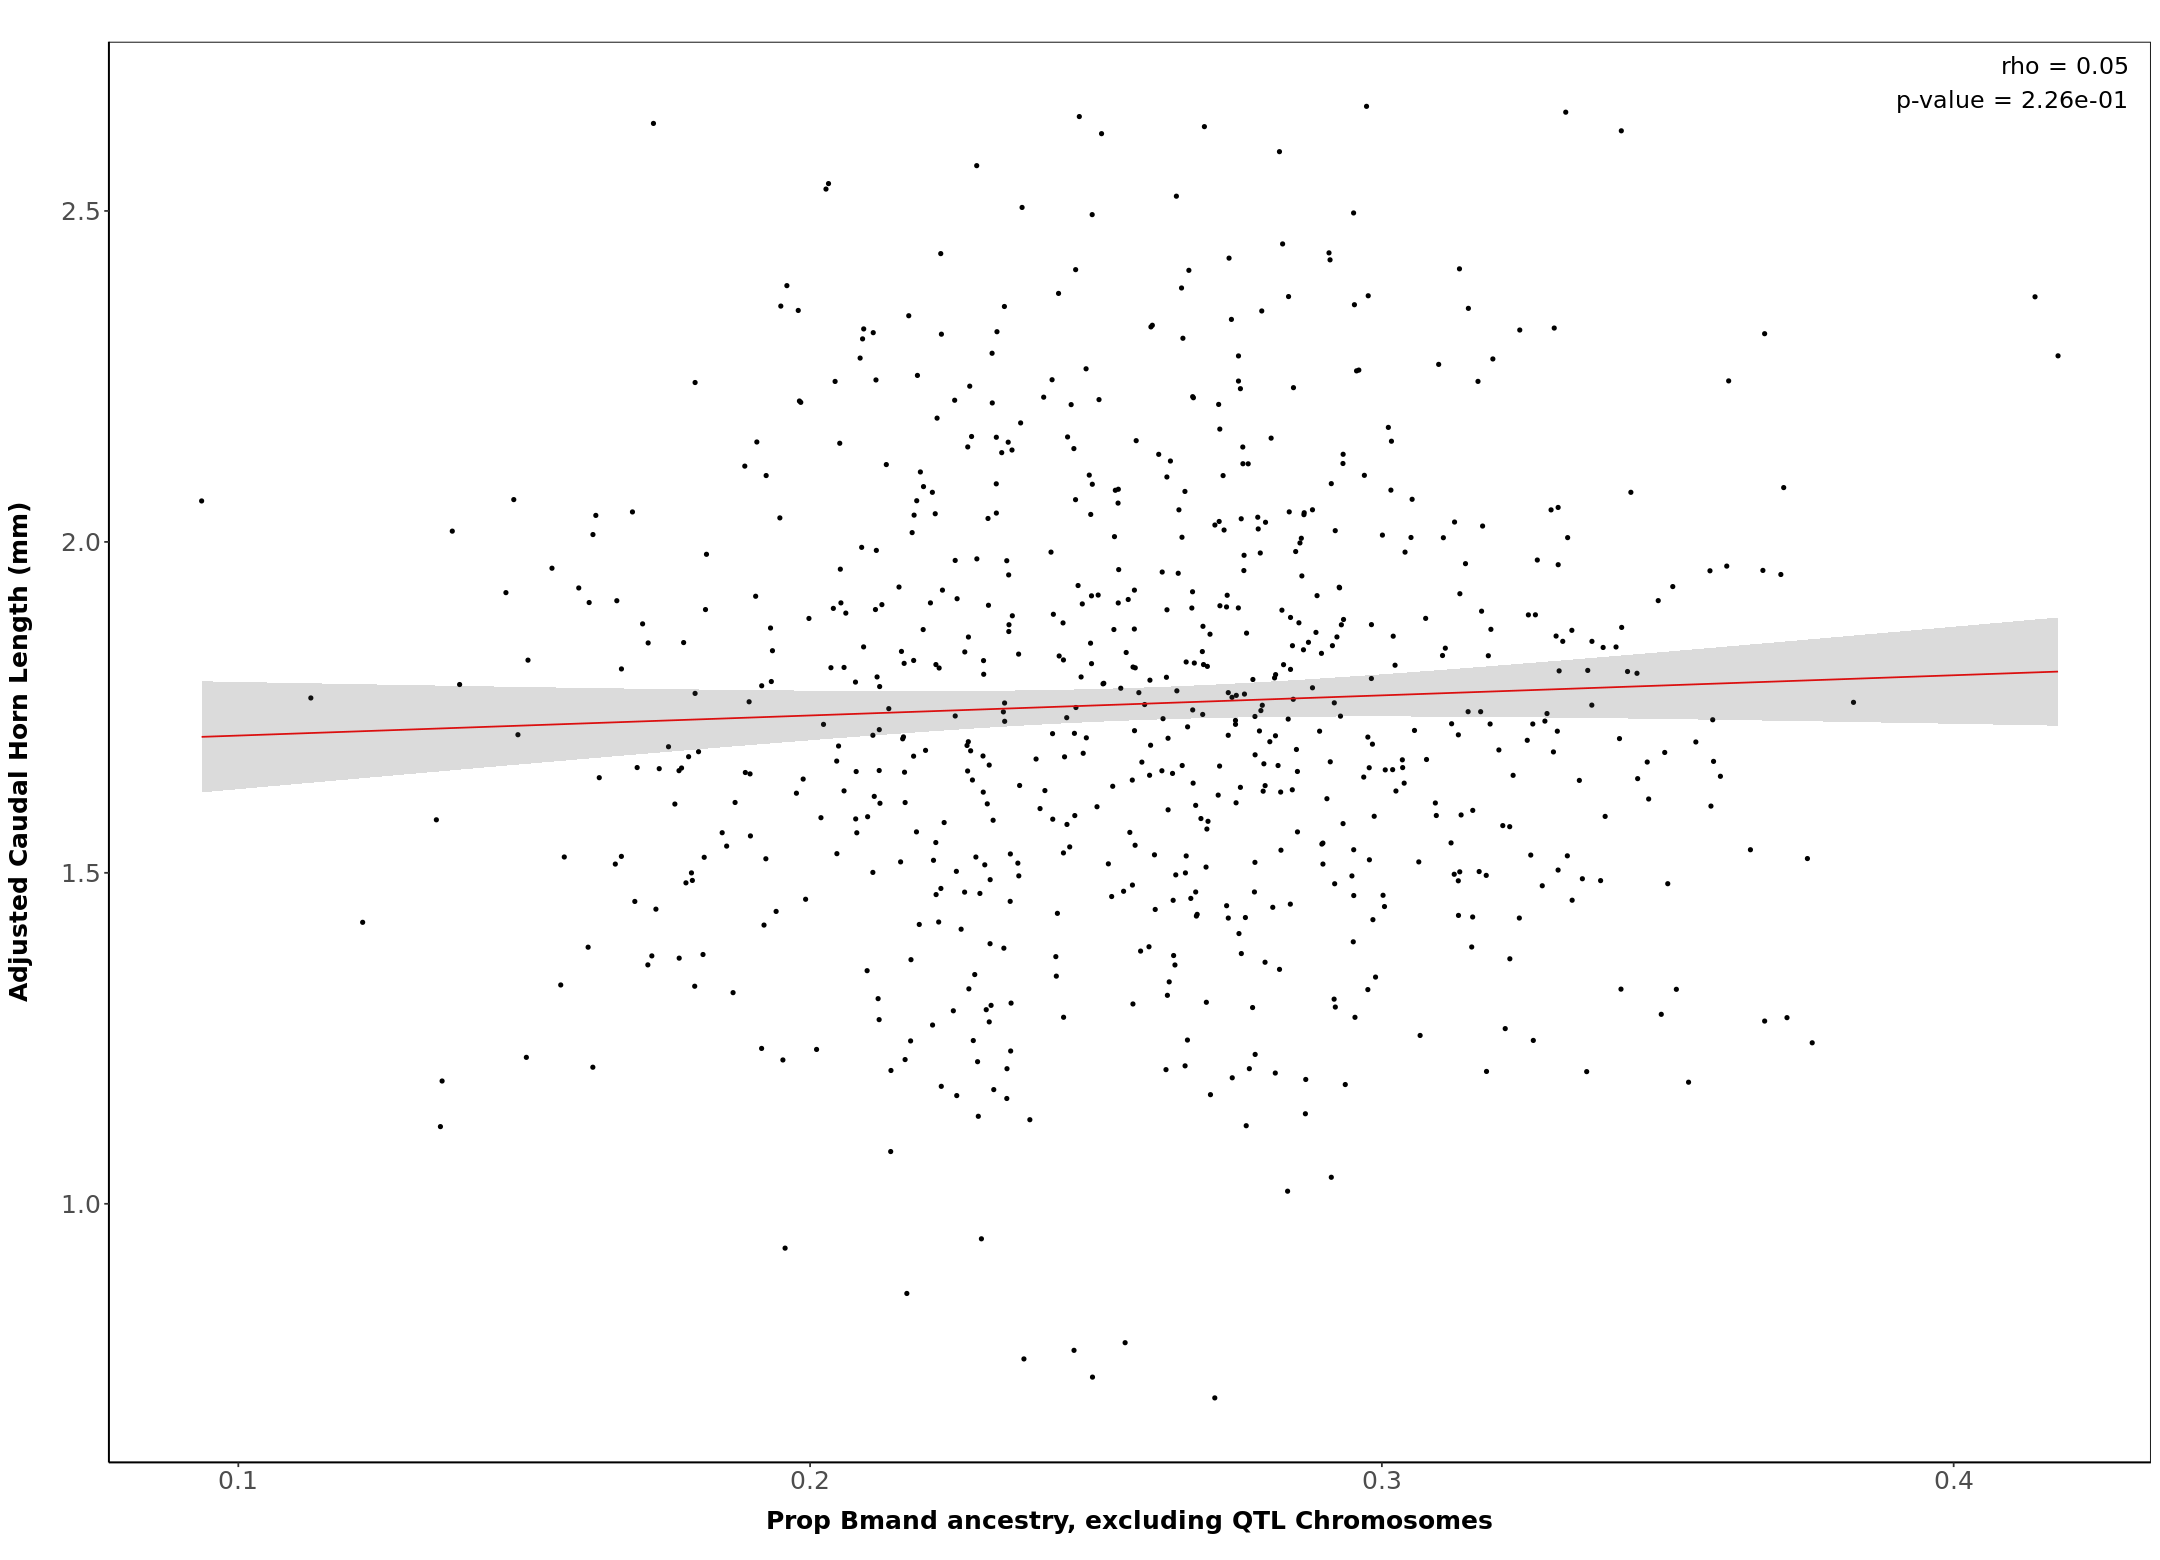

In [126]:
options(repr.plot.width=5, repr.plot.height=5)

BC_length<-ggplot(BC_pheno) +
  geom_point(aes(x = B_ancestry_nonQTL, y = length),size = 0.8) +  # Scatter plot points
  geom_line(data = BC_prediction, aes(x = B_ancestry_nonQTL, y = fit), color = "red") +  # Adjusted regression line
  geom_ribbon(data = BC_prediction, aes(x = B_ancestry_nonQTL, ymin = lwr, ymax = upr), alpha = 0.2, fill = "grey30") +  # Confidence interval
  annotate("text", 
           x = Inf, y = Inf, hjust = 1.1, vjust = 1.3, size=5,
           label = paste("rho =", round(rho, 2), 
                         "\np-value =", format(signif(p_value, 3), scientific = TRUE))) +
theme_bw() +
theme(axis.line = element_line(colour = "black"),
#aspect.ratio=1,
panel.border=element_rect(colour="black", size=0.5),
text=element_text(size=9),
legend.text = element_text(size = 8),
legend.title = element_text(face = "bold", size = 9),
legend.position="bottom",
panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
axis.title.y= element_text(vjust=1,face="bold",size = 15, margin=margin(10,20,10,0)),
axis.title.x = element_text(vjust=1,margin=margin(10,20,10,0),face="bold", size = 15),
axis.text.x = element_text(size=15),
axis.text.y = element_text(size=15),
strip.background = element_blank(),
strip.text.x = element_text(face = "bold"),
strip.text.y = element_text(face = "bold"),
plot.title = element_text(face="bold", size=15))+
labs(x="Prop Bmand ancestry, excluding QTL Chromosomes", y="Adjusted Caudal Horn Length (mm)", title="")
BC_length

#### Repeat same process but using genome-wide B.mand ancestry across all chromosomes

In [127]:
correlation <- cor.test(BC_pheno$B_ancestry_allchrom, BC_pheno$corr_len, method = "pearson")
rho <- correlation$estimate
p_value <- correlation$p.value
correlation


	Pearson's product-moment correlation

data:  BC_pheno$B_ancestry_allchrom and BC_pheno$corr_len
t = 8.7778, df = 692, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2479434 0.3819506
sample estimates:
      cor 
0.3165254 


In [128]:
model <- lm(length ~ B_ancestry_allchrom + sex + weight, data = BC_pheno)
summary(model)
BC_prediction <- data.frame(
  B_ancestry_allchrom = seq(min(BC_pheno$B_ancestry_allchrom), max(BC_pheno$B_ancestry_allchrom), length.out = 100),
  sex = mean(BC_pheno$sex, na.rm = TRUE),
  weight = mean(BC_pheno$weight, na.rm = TRUE)
)

# Predict values and confidence intervals
predicted <- predict(model, newdata = BC_prediction, interval = "confidence")
BC_prediction$fit <- predicted[, "fit"]
BC_prediction$lwr <- predicted[, "lwr"]
BC_prediction$upr <- predicted[, "upr"]



Call:
lm(formula = length ~ B_ancestry_allchrom + sex + weight, data = BC_pheno)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.07080 -0.21081 -0.02083  0.21108  0.85157 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.49372    0.13152   3.754 0.000189 ***
B_ancestry_allchrom  2.48460    0.28222   8.804  < 2e-16 ***
sex                 -0.05255    0.02449  -2.146 0.032219 *  
weight               0.43594    0.06842   6.371 3.43e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3119 on 690 degrees of freedom
Multiple R-squared:  0.1621,	Adjusted R-squared:  0.1585 
F-statistic:  44.5 on 3 and 690 DF,  p-value: < 2.2e-16


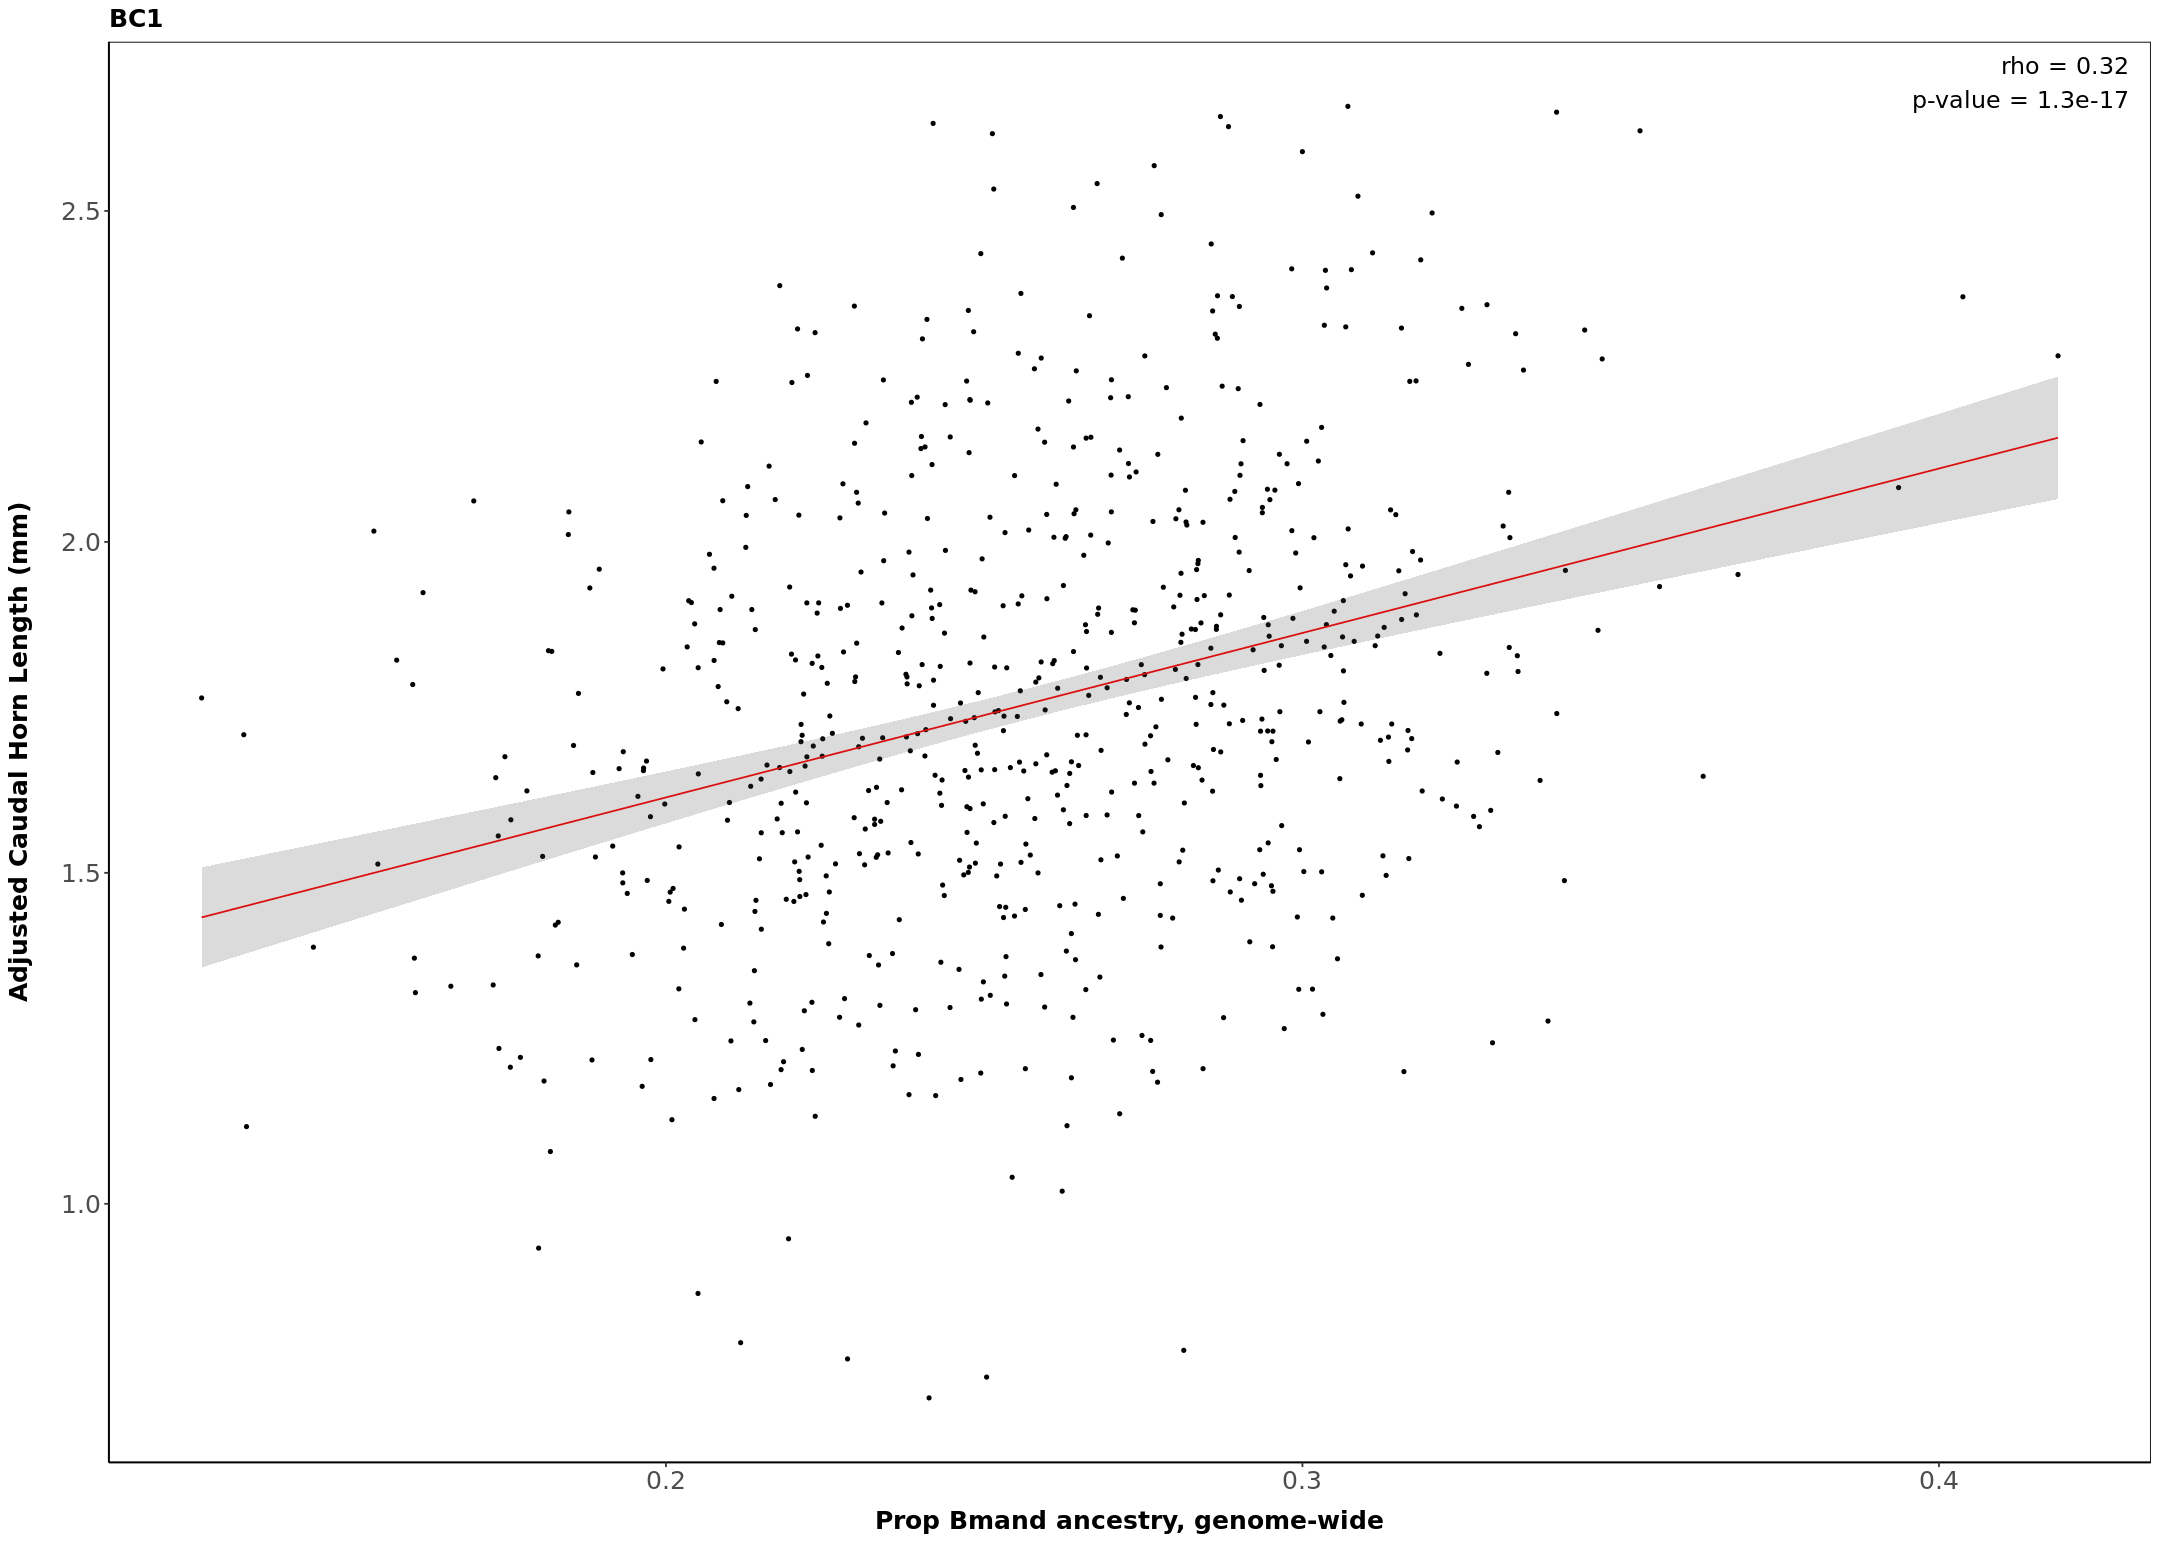

In [129]:
options(repr.plot.width=5, repr.plot.height=5)

BC_length_allchrom<-ggplot(BC_pheno) +
  geom_point(aes(x = B_ancestry_allchrom, y = length),size = 0.8) +  # Scatter plot points
  geom_line(data = BC_prediction, aes(x = B_ancestry_allchrom, y = fit), color = "red") +  # Adjusted regression line
  geom_ribbon(data = BC_prediction, aes(x = B_ancestry_allchrom, ymin = lwr, ymax = upr), alpha = 0.2, fill = "grey30") +  # Confidence interval
  annotate("text", 
           x = Inf, y = Inf, hjust = 1.1, vjust = 1.3, size=5,
           label = paste("rho =", round(rho, 2), 
                         "\np-value =", format(signif(p_value, 3), scientific = TRUE))) +
theme_bw() +
theme(axis.line = element_line(colour = "black"),
#aspect.ratio=1,
panel.border=element_rect(colour="black", size=0.5),
text=element_text(size=9),
legend.text = element_text(size = 8),
legend.title = element_text(face = "bold", size = 9),
legend.position="bottom",
panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
axis.title.y= element_text(vjust=1,face="bold",size = 15, margin=margin(10,20,10,0)),
axis.title.x = element_text(vjust=1,margin=margin(10,20,10,0),face="bold", size = 15),
axis.text.x = element_text(size=15),
axis.text.y = element_text(size=15),
strip.background = element_blank(),
strip.text.x = element_text(face = "bold"),
strip.text.y = element_text(face = "bold"),
plot.title = element_text(face="bold", size=15))+
labs(x="Prop Bmand ancestry, genome-wide", y="Adjusted Caudal Horn Length (mm)", title="BC1")
BC_length_allchrom

### Correlation analysis between corrected CH length and B.mand ancestry in F2s

In [130]:
# Calculate Correlation between corrected length and ancestry excluding QTL chromosomes
F2_correlation <- cor.test(F2_pheno$B_ancestry_nonQTL, F2_pheno$length, method = "pearson")
F2_rho <- F2_correlation$estimate
F2_p_value <- F2_correlation$p.value
F2_correlation


	Pearson's product-moment correlation

data:  F2_pheno$B_ancestry_nonQTL and F2_pheno$length
t = 2.8918, df = 325, p-value = 0.004089
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.05079654 0.26233476
sample estimates:
      cor 
0.1583825 


In [131]:
model <- lm(length ~ B_ancestry_nonQTL + weight, data = F2_pheno)
summary(model)
F2_prediction <- data.frame(
  B_ancestry_nonQTL = seq(min(F2_pheno$B_ancestry_nonQTL), max(F2_pheno$B_ancestry_nonQTL), length.out = 100),
  sex = mean(F2_pheno$sex, na.rm = TRUE),
  weight = mean(F2_pheno$weight, na.rm = TRUE)
)

# Predict values and confidence intervals
predicted <- predict(model, newdata = F2_prediction, interval = "confidence")
F2_prediction$fit <- predicted[, "fit"]
F2_prediction$lwr <- predicted[, "lwr"]
F2_prediction$upr <- predicted[, "upr"]


Call:
lm(formula = length ~ B_ancestry_nonQTL + weight, data = F2_pheno)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.19648 -0.17021  0.02463  0.21739  0.92558 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.2307     0.1913   6.432 4.51e-10 ***
B_ancestry_nonQTL   0.7349     0.2408   3.051  0.00247 ** 
weight              0.2113     0.1039   2.035  0.04271 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3427 on 324 degrees of freedom
Multiple R-squared:  0.03738,	Adjusted R-squared:  0.03144 
F-statistic: 6.291 on 2 and 324 DF,  p-value: 0.002087


In [159]:
options(repr.plot.width=5, repr.plot.height=5)


F2_length<-ggplot(F2_pheno) +
  geom_point(aes(x = B_ancestry_nonQTL, y = length),size = 0.8) +  # Scatter plot points
  geom_line(data = F2_prediction, aes(x = B_ancestry_nonQTL, y = fit), color = "red") +  # Adjusted regression line
  geom_ribbon(data = F2_prediction, aes(x = B_ancestry_nonQTL, ymin = lwr, ymax = upr), alpha = 0.2, fill = "grey30") +  # Confidence interval
  annotate("text", 
           x = Inf, y = Inf, hjust = 1.1, vjust = 1.3, size=5,
           label = paste("rho =", round(F2_rho, 2), 
                         "\np-value =", format(signif(F2_p_value, 3), scientific = TRUE))) +
theme_bw() +
theme(axis.line = element_line(colour = "black"),
#aspect.ratio=1,
panel.border=element_rect(colour="black", size=0.5),
text=element_text(size=9),
legend.text = element_text(size = 8),
legend.title = element_text(face = "bold", size = 9),
legend.position="bottom",
panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
axis.title.y= element_text(vjust=1,face="bold",size = 15, margin=margin(10,20,10,0)),
axis.title.x = element_text(vjust=1,margin=margin(10,20,10,0),face="bold", size = 15),
axis.text.x = element_text(size=15),
axis.text.y = element_text(size=15),
strip.background = element_blank(),
strip.text.x = element_text(face = "bold"),
strip.text.y = element_text(face = "bold"),
plot.title = element_text(face="bold", size=15))+
labs(x="Prop Bmand ancestry, excluding QTL Chromosomes", y="Adjusted Caudal Horn Length (mm)", title="")

F2_length

ERROR while rich displaying an object: Error in `geom_line()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 2nd layer.
Caused by error in `FUN()`:
! object 'B_ancestry_nonQTL' not found

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     

#### Repeat same process for F2s using genome-wide B.mand ancestry across all chromosomes

In [133]:
F2_correlation <- cor.test(F2_pheno$B_ancestry_allchrom, F2_pheno$length, method = "pearson")
F2_rho <- F2_correlation$estimate
F2_p_value <- F2_correlation$p.value
F2_correlation


	Pearson's product-moment correlation

data:  F2_pheno$B_ancestry_allchrom and F2_pheno$length
t = 9.0125, df = 325, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3559656 0.5299188
sample estimates:
      cor 
0.4471604 


In [134]:
model <- lm(length ~ B_ancestry_allchrom + weight, data = F2_pheno)
summary(model)
F2_prediction <- data.frame(
  B_ancestry_allchrom = seq(min(F2_pheno$B_ancestry_allchrom), max(F2_pheno$B_ancestry_allchrom), length.out = 100),
  sex = mean(F2_pheno$sex, na.rm = TRUE),
  weight = mean(F2_pheno$weight, na.rm = TRUE)
)

# Predict values and confidence intervals
predicted <- predict(model, newdata = F2_prediction, interval = "confidence")
F2_prediction$fit <- predicted[, "fit"]
F2_prediction$lwr <- predicted[, "lwr"]
F2_prediction$upr <- predicted[, "upr"]


Call:
lm(formula = length ~ B_ancestry_allchrom + weight, data = F2_pheno)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.24195 -0.13692  0.01461  0.18420  0.85244 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.10582    0.19994   0.529    0.597    
B_ancestry_allchrom  2.63597    0.26834   9.823  < 2e-16 ***
weight               0.37321    0.09414   3.965 9.05e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3051 on 324 degrees of freedom
Multiple R-squared:  0.237,	Adjusted R-squared:  0.2323 
F-statistic: 50.31 on 2 and 324 DF,  p-value: < 2.2e-16


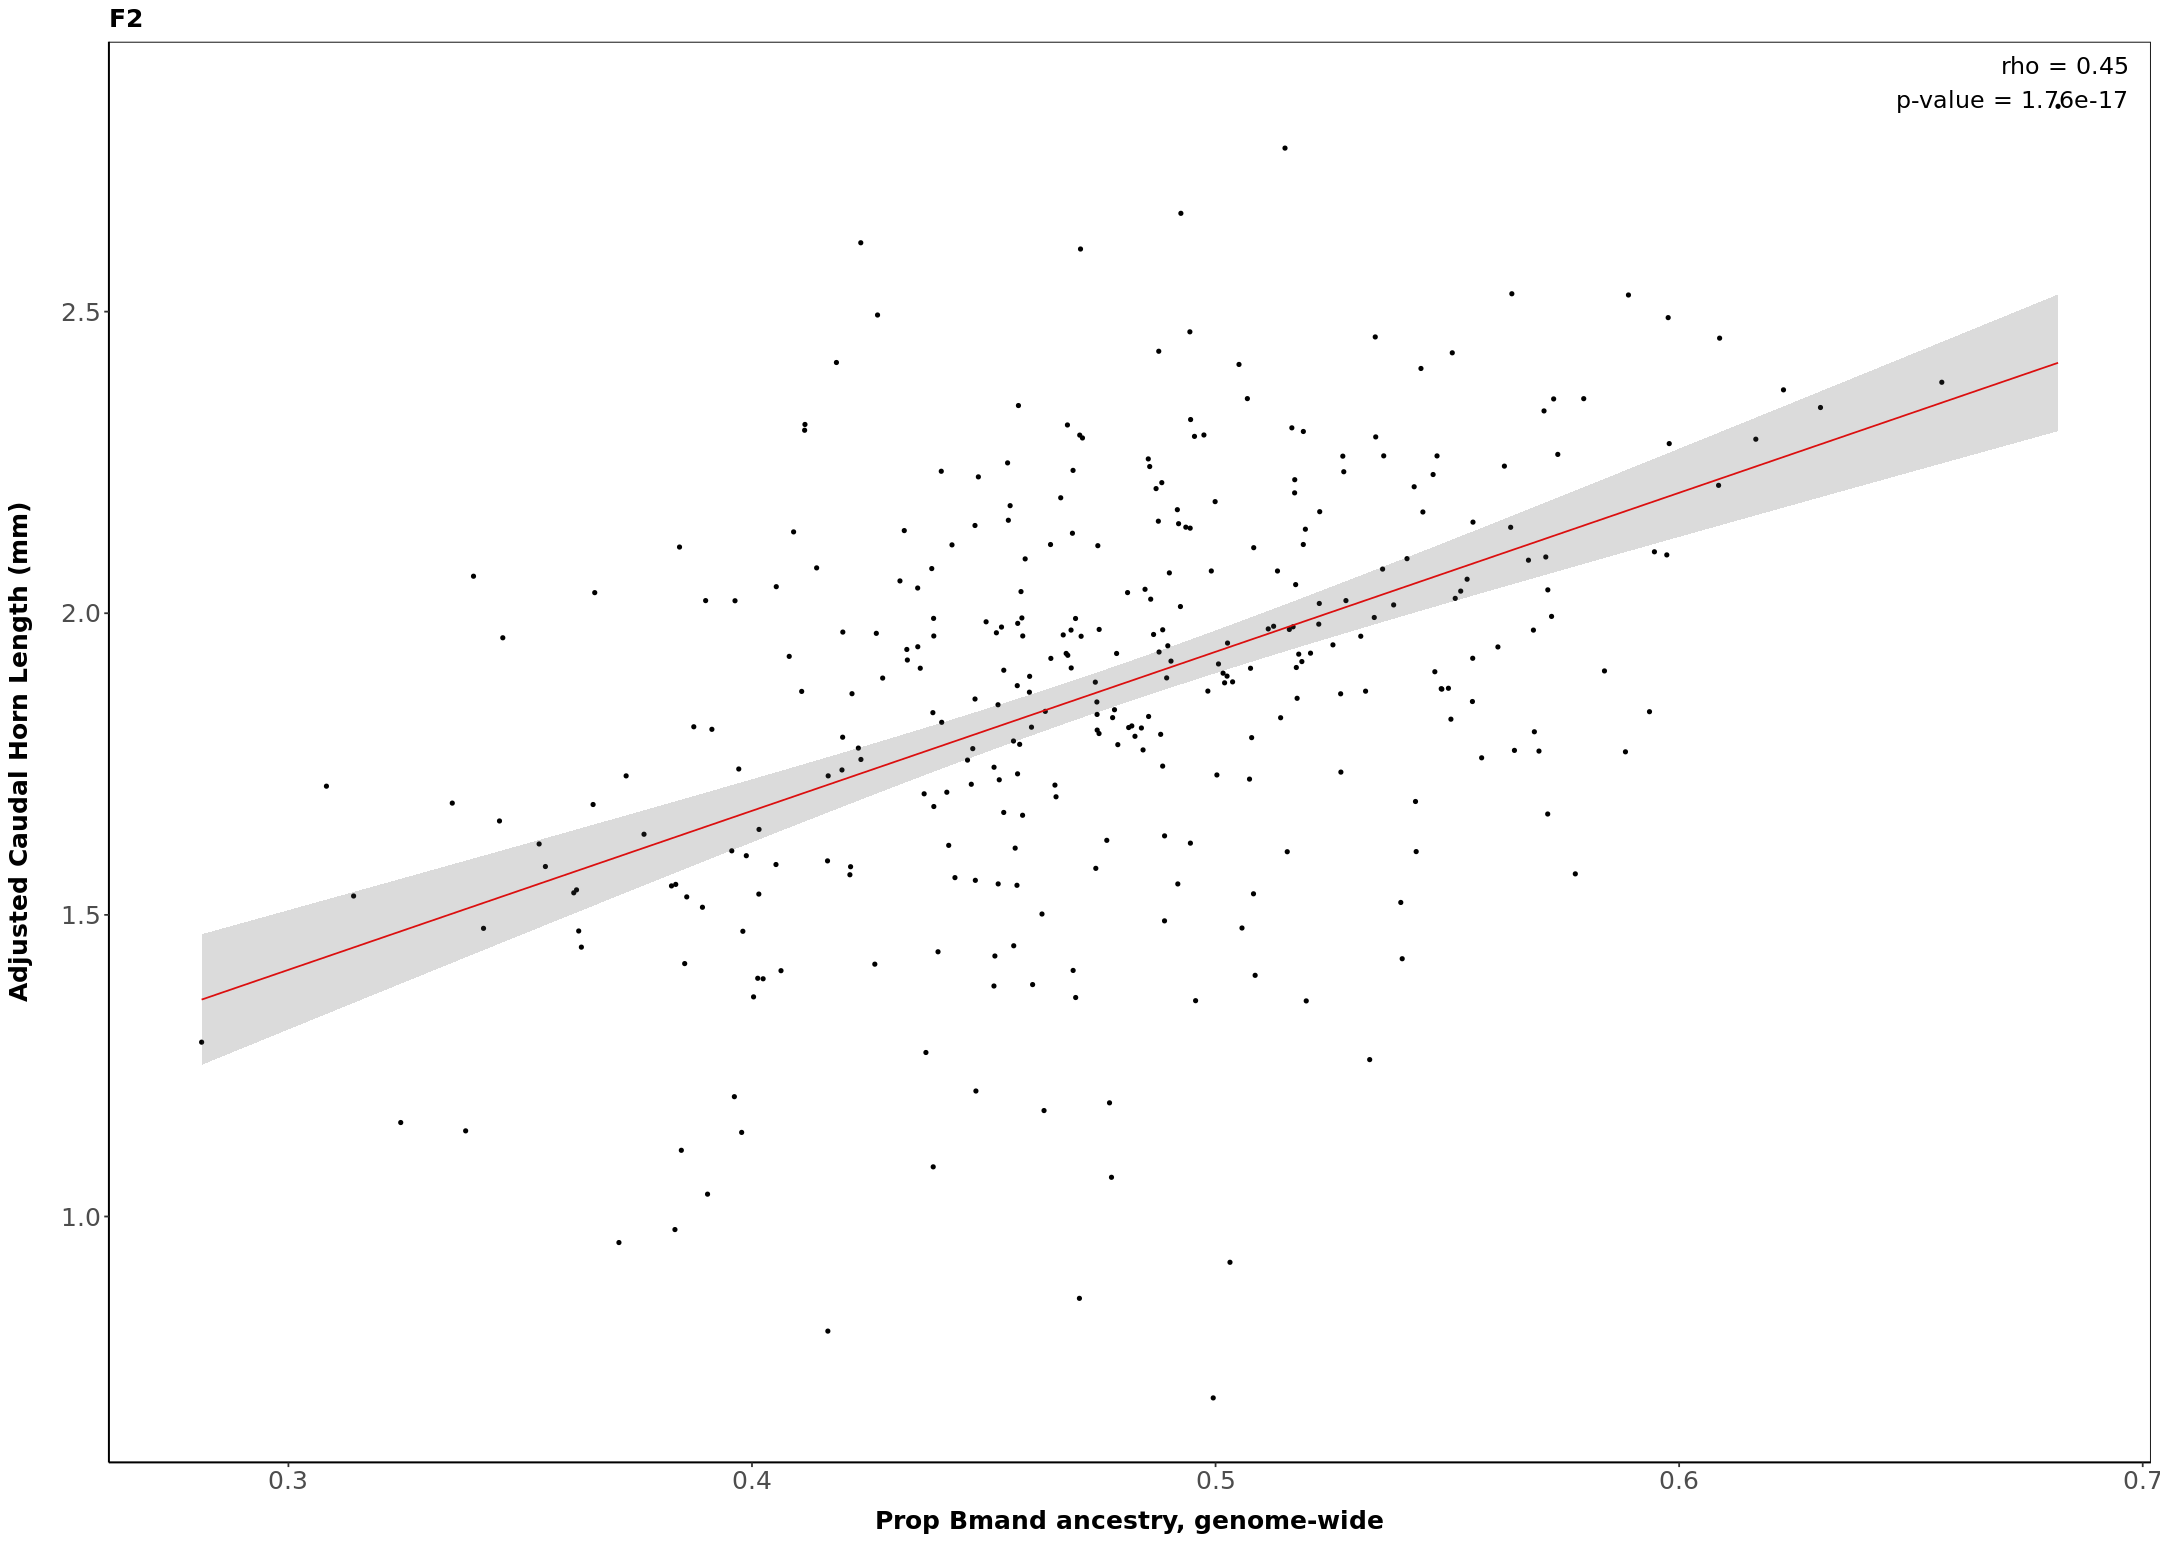

In [135]:
options(repr.plot.width=5, repr.plot.height=5)


F2_length_all<-ggplot(F2_pheno) +
  geom_point(aes(x = B_ancestry_allchrom, y = length),size = 0.8) +  # Scatter plot points
  geom_line(data = F2_prediction, aes(x = B_ancestry_allchrom, y = fit), color = "red") +  # Adjusted regression line
  geom_ribbon(data = F2_prediction, aes(x = B_ancestry_allchrom, ymin = lwr, ymax = upr), alpha = 0.2, fill = "grey30") +  # Confidence interval
  annotate("text", 
           x = Inf, y = Inf, hjust = 1.1, vjust = 1.3, size=5,
           label = paste("rho =", round(F2_rho, 2), 
                         "\np-value =", format(signif(F2_p_value, 3), scientific = TRUE))) +
theme_bw() +
theme(axis.line = element_line(colour = "black"),
#aspect.ratio=1,
panel.border=element_rect(colour="black", size=0.5),
text=element_text(size=9),
legend.text = element_text(size = 8),
legend.title = element_text(face = "bold", size = 9),
legend.position="bottom",
panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
axis.title.y= element_text(vjust=1,face="bold",size = 15, margin=margin(10,20,10,0)),
axis.title.x = element_text(vjust=1,margin=margin(10,20,10,0),face="bold", size = 15),
axis.text.x = element_text(size=15),
axis.text.y = element_text(size=15),
strip.background = element_blank(),
strip.text.x = element_text(face = "bold"),
strip.text.y = element_text(face = "bold"),
plot.title = element_text(face="bold", size=15))+
labs(x="Prop Bmand ancestry, genome-wide",  y="Adjusted Caudal Horn Length (mm)", title="F2")

F2_length_all

## Calculate Effect Sizes for F2 CH Length using per-chromosome B.mand ancestry

#### Generate Full model

In [136]:
F2_melt$sex<-ifelse(F2_melt$sex==1, 0, ifelse(F2_melt$sex==0, 1, NA))

full_model <- lm(as.formula(paste0("length ~ ", paste(c("sex", "weight", paste0("Chr", c(seq(1,26,1), 28))), collapse= "+"))), 
                 data = F2_melt)
summary(full_model)


Call:
lm(formula = as.formula(paste0("length ~ ", paste(c("sex", "weight", 
    paste0("Chr", c(seq(1, 26, 1), 28))), collapse = "+"))), 
    data = F2_melt)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.18066 -0.13258  0.01358  0.17083  0.77426 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.17764    0.20281   0.876 0.381800    
sex         -0.01142    0.03717  -0.307 0.758955    
weight       0.34336    0.10292   3.336 0.000957 ***
Chr1         0.11398    0.05469   2.084 0.038008 *  
Chr2         0.07871    0.04901   1.606 0.109341    
Chr3         0.25130    0.05215   4.819 2.31e-06 ***
Chr4         0.42390    0.04828   8.781  < 2e-16 ***
Chr5         0.10717    0.05492   1.951 0.051953 .  
Chr6         0.05129    0.05187   0.989 0.323523    
Chr7         0.14256    0.04873   2.926 0.003702 ** 
Chr8         0.14249    0.05454   2.613 0.009437 ** 
Chr9         0.07585    0.05110   1.484 0.138764    
Chr10        0.07833    0.04942  

#### Generate Reduced Model using BIC

In [137]:
n <- nobs(full_model)
reduced_model<- step(full_model, k=log(n))

Start:  AIC=-703.32
length ~ sex + weight + Chr1 + Chr2 + Chr3 + Chr4 + Chr5 + Chr6 + 
    Chr7 + Chr8 + Chr9 + Chr10 + Chr11 + Chr12 + Chr13 + Chr14 + 
    Chr15 + Chr16 + Chr17 + Chr18 + Chr19 + Chr20 + Chr21 + Chr22 + 
    Chr23 + Chr24 + Chr25 + Chr26 + Chr28

         Df Sum of Sq    RSS     AIC
- Chr16   1    0.0024 22.378 -709.07
- sex     1    0.0071 22.382 -709.00
- Chr13   1    0.0234 22.398 -708.77
- Chr12   1    0.0341 22.409 -708.61
- Chr19   1    0.0661 22.441 -708.14
- Chr6    1    0.0737 22.449 -708.03
- Chr23   1    0.0787 22.454 -707.96
- Chr17   1    0.1049 22.480 -707.58
- Chr25   1    0.1360 22.511 -707.13
- Chr9    1    0.1660 22.541 -706.69
- Chr28   1    0.1755 22.551 -706.55
- Chr10   1    0.1892 22.564 -706.35
- Chr14   1    0.1918 22.567 -706.32
- Chr11   1    0.1928 22.568 -706.30
- Chr2    1    0.1943 22.569 -706.28
- Chr20   1    0.1946 22.570 -706.28
- Chr24   1    0.2381 22.613 -705.65
- Chr5    1    0.2869 22.662 -704.94
- Chr1    1    0.3272 22.702 -70

In [138]:
# Reduced Model Summary
summary_stats <- summary(reduced_model)
summary_stats


Call:
lm(formula = length ~ weight + Chr1 + Chr3 + Chr4 + Chr7 + Chr8 + 
    Chr18 + Chr21 + Chr26, data = F2_melt)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.27947 -0.13629  0.01516  0.17276  0.88488 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.68429    0.14932   4.583 6.61e-06 ***
weight       0.33219    0.08970   3.703 0.000251 ***
Chr1         0.15747    0.04795   3.284 0.001139 ** 
Chr3         0.23538    0.05243   4.490 1.00e-05 ***
Chr4         0.44981    0.04828   9.318  < 2e-16 ***
Chr7         0.13628    0.04901   2.781 0.005750 ** 
Chr8         0.14833    0.05429   2.732 0.006642 ** 
Chr18        0.13796    0.05300   2.603 0.009674 ** 
Chr21        0.13893    0.05072   2.739 0.006503 ** 
Chr26        0.13237    0.05068   2.612 0.009431 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2829 on 317 degrees of freedom
Multiple R-squared:  0.3583,	Adjusted R-squared:  0.340

In [139]:
# Get p-values
p_values <- summary_stats$coefficients[, "Pr(>|t|)"]


# Remove the intercept if it exists in the p-values
if ("(Intercept)" %in% names(p_values)) {
  p_values <- p_values[-which(names(p_values) == "(Intercept)")]
}


# Adjust the p-values
adjusted_p_values <- p.adjust(p_values, method = "bonferroni")


# Handle Inf by replacing with a very large number 
adjusted_p_values[adjusted_p_values == 0] <- .Machine$double.xmin


# Calculate log10 of adjusted p-values
log10_adjusted_p_values <- -log10(adjusted_p_values)


# Create a data frame or add to existing one
result_reduced_model <- data.frame(
  predictor = names(adjusted_p_values),
  p_value = p_values,
  adjusted_p_value = adjusted_p_values,
  log10_adjusted_p_value = log10_adjusted_p_values
)


result_reduced_model

,predictor,p_value,adjusted_p_value,log10_adjusted_p_value
,<chr>,<dbl>,<dbl>,<dbl>
weight,weight,2.509656e-04,2.258690e-03,2.646143
Chr1,Chr1,1.138812e-03,1.024931e-02,1.989305
Chr3,Chr3,9.999675e-06,8.999708e-05,4.045772
Chr4,Chr4,2.077710e-18,1.869939e-17,16.728173
Chr7,Chr7,5.750020e-03,5.175018e-02,1.286088
Chr8,Chr8,6.642421e-03,5.978179e-02,1.223431
Chr18,Chr18,9.674143e-03,8.706729e-02,1.060145
Chr21,Chr21,6.502548e-03,5.852293e-02,1.232674
Chr26,Chr26,9.431271e-03,8.488144e-02,1.071187


In [140]:
# Get chromosomes that were significant in the reduced model after p-value adjustment
significant_chrs<-result_reduced_model$predictor
significant_chrs

[1] "weight" "Chr1"   "Chr3"   "Chr4"   "Chr7"   "Chr8"   "Chr18"  "Chr21" 
[9] "Chr26"

In [141]:
F2_melt_std <- F2_melt
for (ancestry_chr in c(significant_chrs, "sex", "weight")) {
  if (!is.null(F2_melt_std[[ancestry_chr]])) {
    F2_melt_std[[ancestry_chr]] <- scale(F2_melt_std[[ancestry_chr]])
  } else if (chr %in% c("sex", "weight")) {
    F2_melt_std[[chr]] <- scale(F2_melt_std[[chr]])
  } else {
    warning(paste("Column", ancestry_chr, "not found in filtered_data"))
  }
}


In [142]:
# print reduced model
formula(reduced_model)

length ~ weight + Chr1 + Chr3 + Chr4 + Chr7 + Chr8 + Chr18 + 
    Chr21 + Chr26

In [143]:
# get coefficients of reduced model and standard deviations
coefs <- coef(reduced_model)
std_model <- lm(formula(reduced_model), data = F2_melt_std)
std_coefficients <- coef(std_model)[-1]  # Exclude the intercept
summary(std_model)


Call:
lm(formula = formula(reduced_model), data = F2_melt_std)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.27947 -0.13629  0.01516  0.17276  0.88488 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.87423    0.01564 119.803  < 2e-16 ***
weight       0.06088    0.01644   3.703 0.000251 ***
Chr1         0.05324    0.01621   3.284 0.001139 ** 
Chr3         0.07133    0.01589   4.490    1e-05 ***
Chr4         0.14708    0.01579   9.318  < 2e-16 ***
Chr7         0.04383    0.01576   2.781 0.005750 ** 
Chr8         0.04363    0.01597   2.732 0.006642 ** 
Chr18        0.04128    0.01586   2.603 0.009674 ** 
Chr21        0.04343    0.01585   2.739 0.006503 ** 
Chr26        0.04234    0.01621   2.612 0.009431 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2829 on 317 degrees of freedom
Multiple R-squared:  0.3583,	Adjusted R-squared:  0.3401 
F-statistic: 19.67 on 9 and 317 DF,  p-value: < 2.

In [144]:
# Create a data frame with chromosome names and standardized coefficients
effect_sizes_table <- data.frame(
  chr = names(std_coefficients),
  effect_size = as.numeric(std_coefficients)
)


effect_sizes_table$log10_adjusted_p_value<-result_reduced_model$log10_adjusted_p_value
effect_sizes_table$adjusted_p_value<-result_reduced_model$adjusted_p_value

effect_sizes_table_sig_only<-effect_sizes_table
effect_sizes_table_sig_only$p_value<- result_reduced_model$p_value
effect_sizes_table_sig_only$log10_p_value<- -log10(result_reduced_model$p_value)


effect_sizes_table_sig_only

chr,effect_size,log10_adjusted_p_value,adjusted_p_value,p_value,log10_p_value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
weight,0.06088036,2.646143,2.258690e-03,2.509656e-04,3.600386
Chr1,0.05324344,1.989305,1.024931e-02,1.138812e-03,2.943548
Chr3,0.07133405,4.045772,8.999708e-05,9.999675e-06,5.000014
Chr4,0.14708481,16.728173,1.869939e-17,2.077710e-18,17.682415
Chr7,0.04382598,1.286088,5.175018e-02,5.750020e-03,2.240331
Chr8,0.04363109,1.223431,5.978179e-02,6.642421e-03,2.177674
Chr18,0.04127913,1.060145,8.706729e-02,9.674143e-03,2.014388
Chr21,0.04343328,1.232674,5.852293e-02,6.502548e-03,2.186916
Chr26,0.04233547,1.071187,8.488144e-02,9.431271e-03,2.025430


In [145]:
library(ggtext)

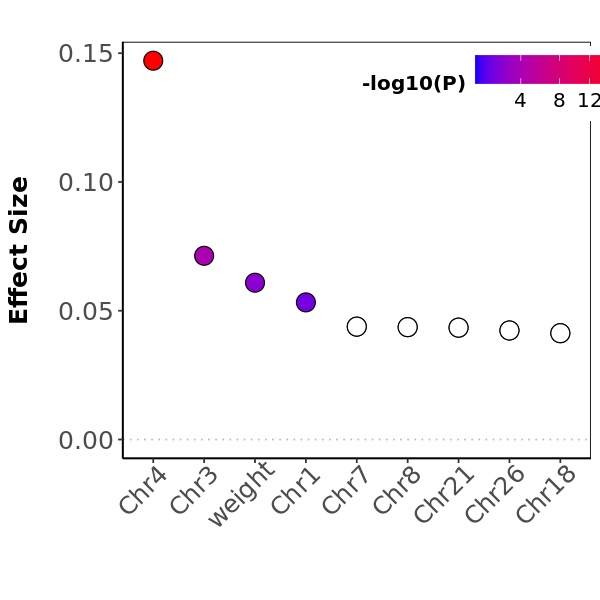

In [146]:
options(repr.plot.width=5, repr.plot.height=5)

effect_sizes_table_F2_nonsig<-effect_sizes_table_sig_only[which(effect_sizes_table_sig_only$adjusted_p_value>0.05),]


F2_effect_plot<-ggplot(effect_sizes_table_sig_only, 
                       aes(x = reorder(chr, -effect_size), y = effect_size, 
                           fill=log10_adjusted_p_value)) +
  geom_hline(yintercept=0, linetype="dotted", color = "grey") +
  geom_point(size=5, pch=21, color="black") +
  geom_point(data=effect_sizes_table_F2_nonsig, 
             aes(x = reorder(chr, -effect_size), y = effect_size), fill="white",
             size=5, pch=21, color="black") +

 # scale_x_discrete(labels = effect_sizes_table$label) +
  theme_bw() +
  theme(axis.line = element_line(colour = "black"),
 #       aspect.ratio=1,
        panel.border=element_rect(colour="black", size=0.5),
        text=element_text(size=12),
        legend.text = element_text(size = 12),
        legend.title = element_text(face = "bold", size = 12),
        #legend.position="bottom",
        legend.direction = "horizontal",
        legend.position = c(.8, 0.9),
        legend.title.align=1,
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.title.y= element_text(vjust=1,face="bold",size = 15, margin=margin(10,20,10,0)),
        axis.title.x = element_text(vjust=1,margin=margin(10,20,10,0),face="bold", size = 15),
        axis.text.x = element_markdown(size=15, angle=45,vjust=1,hjust=1), # Note this line
        axis.text.y = element_text(size=15),
        strip.background = element_blank(),
        strip.text.x = element_text(face = "bold"),
        strip.text.y = element_text(face = "bold"),
        plot.title = element_text(face="bold", size=15)) + 
  labs(title = "",
       x = "",
       y = "Effect Size",
      color = "-log10(P)")+#+ ylim(-0.05,0.13)
#scale_color_gradient(low = "blue", high = "red", name = "-log10(P)")+
#scale_fill_viridis_c(option = "plasma", name = "-log10(P)")
scale_fill_gradient(low = "blue", high = "red", name = "-log10(P)", trans = "sqrt")

F2_effect_plot



## Calculate Effect Sizes for BC CH Length using per-chromosome B.mand ancestry

Repeat the same process as in the F2s

In [147]:
BC_melt$sex<-ifelse(BC_melt$sex==1, 0, ifelse(BC_melt$sex==0, 1, NA))

# Generate Full Model
full_model <- lm(as.formula(paste0("length ~ ", paste(c("sex", "weight", paste0("Chr", c(seq(1,26,1), 28))), collapse= "+"))), 
                 data = BC_melt)
summary(full_model)


Call:
lm(formula = as.formula(paste0("length ~ ", paste(c("sex", "weight", 
    paste0("Chr", c(seq(1, 26, 1), 28))), collapse = "+"))), 
    data = BC_melt)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.06309 -0.15618  0.01671  0.16674  0.95383 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.571163   0.108265   5.276 1.79e-07 ***
sex          0.099923   0.021304   4.690 3.31e-06 ***
weight       0.322614   0.059739   5.400 9.27e-08 ***
Chr1        -0.079584   0.031635  -2.516 0.012115 *  
Chr2         0.139660   0.046473   3.005 0.002754 ** 
Chr3         0.211518   0.050852   4.159 3.61e-05 ***
Chr4         0.621221   0.049743  12.489  < 2e-16 ***
Chr5         0.247301   0.053270   4.642 4.15e-06 ***
Chr6         0.185956   0.050632   3.673 0.000259 ***
Chr7         0.199619   0.050275   3.971 7.95e-05 ***
Chr8         0.020661   0.051177   0.404 0.686554    
Chr9         0.170698   0.048876   3.492 0.000510 ***
Chr10        0.24593

In [148]:
n <- nobs(full_model)
reduced_model<- step(full_model, k=log(n))

Start:  AIC=-1699.74
length ~ sex + weight + Chr1 + Chr2 + Chr3 + Chr4 + Chr5 + Chr6 + 
    Chr7 + Chr8 + Chr9 + Chr10 + Chr11 + Chr12 + Chr13 + Chr14 + 
    Chr15 + Chr16 + Chr17 + Chr18 + Chr19 + Chr20 + Chr21 + Chr22 + 
    Chr23 + Chr24 + Chr25 + Chr26 + Chr28

         Df Sum of Sq    RSS     AIC
- Chr17   1    0.0003 45.171 -1706.3
- Chr24   1    0.0024 45.173 -1706.2
- Chr18   1    0.0052 45.176 -1706.2
- Chr8    1    0.0111 45.182 -1706.1
- Chr23   1    0.0180 45.189 -1706.0
- Chr22   1    0.0218 45.193 -1706.0
- Chr12   1    0.0465 45.218 -1705.6
- Chr13   1    0.0712 45.242 -1705.2
- Chr16   1    0.0777 45.249 -1705.1
- Chr28   1    0.0851 45.256 -1705.0
- Chr20   1    0.1020 45.273 -1704.7
- Chr14   1    0.1269 45.298 -1704.3
- Chr19   1    0.2676 45.439 -1702.2
- Chr11   1    0.3188 45.490 -1701.4
- Chr15   1    0.3752 45.546 -1700.5
<none>                45.171 -1699.7
- Chr1    1    0.4305 45.602 -1699.7
- Chr2    1    0.6144 45.785 -1696.9
- Chr9    1    0.8298 46.001 -1

In [149]:
summary_stats <- summary(reduced_model)
summary_stats


Call:
lm(formula = length ~ sex + weight + Chr2 + Chr3 + Chr4 + Chr5 + 
    Chr6 + Chr7 + Chr9 + Chr10 + Chr15 + Chr21 + Chr25 + Chr26, 
    data = BC_melt)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.05388 -0.15962  0.01164  0.16353  0.90842 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.46273    0.09312   4.969 8.51e-07 ***
sex          0.08246    0.02059   4.005 6.90e-05 ***
weight       0.35811    0.05824   6.148 1.33e-09 ***
Chr2         0.12657    0.04604   2.749 0.006132 ** 
Chr3         0.21432    0.05038   4.254 2.40e-05 ***
Chr4         0.63277    0.04974  12.721  < 2e-16 ***
Chr5         0.24204    0.05288   4.577 5.60e-06 ***
Chr6         0.18901    0.05034   3.755 0.000188 ***
Chr7         0.19306    0.04986   3.872 0.000118 ***
Chr9         0.17039    0.04876   3.495 0.000505 ***
Chr10        0.24598    0.04757   5.171 3.07e-07 ***
Chr15        0.12701    0.04844   2.622 0.008944 ** 
Chr21        0.37345    0.05009   

In [150]:
p_values <- summary_stats$coefficients[, "Pr(>|t|)"]


# Remove the intercept if it exists in the p-values
if ("(Intercept)" %in% names(p_values)) {
  p_values <- p_values[-which(names(p_values) == "(Intercept)")]
}


# Adjust the p-values
adjusted_p_values <- p.adjust(p_values, method = "bonferroni")


# Handle Inf by replacing with a very large number 
adjusted_p_values[adjusted_p_values == 0] <- .Machine$double.xmin


# Calculate log10 of adjusted p-values
log10_adjusted_p_values <- -log10(adjusted_p_values)


# Create a data frame or add to existing one
result_reduced_model <- data.frame(
  predictor = names(adjusted_p_values),
  p_value = p_values,
  adjusted_p_value = adjusted_p_values,
  log10_adjusted_p_value = log10_adjusted_p_values
)


result_reduced_model

,predictor,p_value,adjusted_p_value,log10_adjusted_p_value
,<chr>,<dbl>,<dbl>,<dbl>
sex,sex,6.898517e-05,9.657923e-04,3.0151162
weight,weight,1.334558e-09,1.868381e-08,7.7285345
Chr2,Chr2,6.132191e-03,8.585067e-02,1.0662563
Chr3,Chr3,2.395978e-05,3.354369e-04,3.4743891
Chr4,Chr4,2.109540e-33,2.953356e-32,31.5296842
Chr5,Chr5,5.604935e-06,7.846908e-05,4.1053014
Chr6,Chr6,1.883500e-04,2.636901e-03,2.5789062
Chr7,Chr7,1.184114e-04,1.657760e-03,2.7804783
Chr9,Chr9,5.053581e-04,7.075014e-03,2.1502727


In [151]:
significant_chrs<-result_reduced_model$predictor
significant_chrs

[1] "sex"    "weight" "Chr2"   "Chr3"   "Chr4"   "Chr5"   "Chr6"   "Chr7"  
 [9] "Chr9"   "Chr10"  "Chr15"  "Chr21"  "Chr25"  "Chr26"

In [152]:
BC_melt_std <- BC_melt
for (ancestry_chr in c(significant_chrs, "sex", "weight")) {
  if (!is.null(BC_melt_std[[ancestry_chr]])) {
    BC_melt_std[[ancestry_chr]] <- scale(BC_melt_std[[ancestry_chr]])
  } else if (chr %in% c("sex", "weight")) {
    BC_melt_std[[chr]] <- scale(BC_melt_std[[chr]])
  } else {
    warning(paste("Column", ancestry_chr, "not found in filtered_data"))
  }
}


In [153]:
coefs <- coef(reduced_model)
std_model <- lm(formula(reduced_model), data = BC_melt_std)
std_coefficients <- coef(std_model)[-1]  # Exclude the intercept
summary(std_model)


Call:
lm(formula = formula(reduced_model), data = BC_melt_std)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.05388 -0.15962  0.01164  0.16353  0.90842 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.755471   0.009959 176.269  < 2e-16 ***
sex         0.041245   0.010299   4.005 6.90e-05 ***
weight      0.063932   0.010398   6.148 1.33e-09 ***
Chr2        0.027548   0.010020   2.749 0.006132 ** 
Chr3        0.042655   0.010027   4.254 2.40e-05 ***
Chr4        0.129167   0.010154  12.721  < 2e-16 ***
Chr5        0.046741   0.010212   4.577 5.60e-06 ***
Chr6        0.037721   0.010046   3.755 0.000188 ***
Chr7        0.038861   0.010037   3.872 0.000118 ***
Chr9        0.035050   0.010029   3.495 0.000505 ***
Chr10       0.051915   0.010040   5.171 3.07e-07 ***
Chr15       0.026408   0.010072   2.622 0.008944 ** 
Chr21       0.075062   0.010068   7.455 2.74e-13 ***
Chr25       0.035182   0.010068   3.494 0.000506 ***
Chr26       0.034910  

In [154]:
# Create a data frame with chromosome names and standardized coefficients
effect_sizes_table_BC <- data.frame(
  chr = names(std_coefficients),
  effect_size = as.numeric(std_coefficients)
)

effect_sizes_table_BC$p_value<- result_reduced_model$p_value
effect_sizes_table_BC$log10_p_value<- -log10(result_reduced_model$p_value)
effect_sizes_table_BC$log10_adjusted_p_value<-result_reduced_model$log10_adjusted_p_value
effect_sizes_table_BC$adjusted_p_value<-result_reduced_model$adjusted_p_value

effect_sizes_table_BC_sig_only<-effect_sizes_table_BC
effect_sizes_table_BC_sig_only

chr,effect_size,p_value,log10_p_value,log10_adjusted_p_value,adjusted_p_value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sex,0.04124462,6.898517e-05,4.161244,3.0151162,9.657923e-04
weight,0.06393214,1.334558e-09,8.874663,7.7285345,1.868381e-08
Chr2,0.02754785,6.132191e-03,2.212384,1.0662563,8.585067e-02
Chr3,0.04265507,2.395978e-05,4.620517,3.4743891,3.354369e-04
Chr4,0.12916743,2.109540e-33,32.675812,31.5296842,2.953356e-32
Chr5,0.04674096,5.604935e-06,5.251429,4.1053014,7.846908e-05
Chr6,0.03772112,1.883500e-04,3.725034,2.5789062,2.636901e-03
Chr7,0.03886094,1.184114e-04,3.926606,2.7804783,1.657760e-03
Chr9,0.03504954,5.053581e-04,3.296401,2.1502727,7.075014e-03


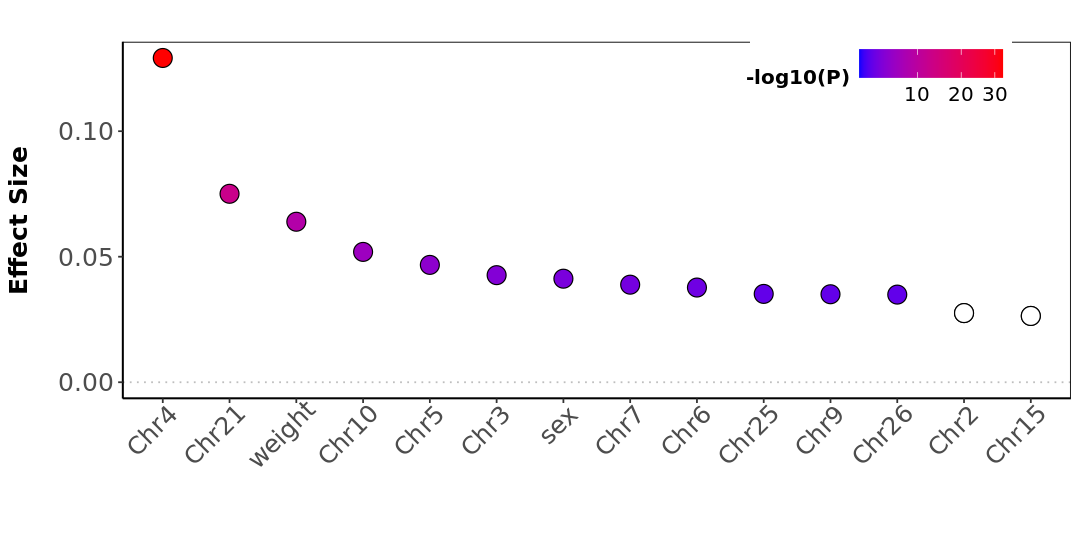

In [155]:
options(repr.plot.width=9, repr.plot.height=4.5)

effect_sizes_table_BC_nonsig<-effect_sizes_table_BC_sig_only[which(effect_sizes_table_BC_sig_only$adjusted_p_value>0.05),]

BC_effect_plot<-ggplot(effect_sizes_table_BC_sig_only, 
                       aes(x = reorder(chr, -effect_size), y = effect_size, 
                           fill=log10_p_value)) +
  geom_hline(yintercept=0, linetype="dotted", color = "grey") +
  geom_point(size=5, color = "black", pch=21) +
  geom_point(data=effect_sizes_table_BC_nonsig,
             aes(x = reorder(chr, -effect_size), y = effect_size),
             size=5, color = "black", pch=21, fill = "white") +

 # scale_x_discrete(labels = effect_sizes_table$label) +
  theme_bw() +
  theme(axis.line = element_line(colour = "black"),
#        aspect.ratio=1,
        panel.border=element_rect(colour="black", size=0.5),
        text=element_text(size=12),
        legend.text = element_text(size = 12),
        legend.title = element_text(face = "bold", size = 12),
        #legend.position="bottom",
        legend.direction = "horizontal",
        legend.position = c(.8, 0.9),
        legend.title.align=1,
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        axis.title.y= element_text(vjust=1,face="bold",size = 15, margin=margin(10,20,10,0)),
        axis.title.x = element_text(vjust=1,margin=margin(10,20,10,0),face="bold", size = 15),
        axis.text.x = element_markdown(size=15, angle=45,vjust=1,hjust=1), # Note this line
        axis.text.y = element_text(size=15),
        strip.background = element_blank(),
        strip.text.x = element_text(face = "bold"),
        strip.text.y = element_text(face = "bold"),
        plot.title = element_text(face="bold", size=15)) + 
  labs(title = "",
       x = "",
       y = "Effect Size",
      color = "-log10(P)")+#+ ylim(-0.05,0.13)
#scale_fill_viridis_c(option = "plasma", name = "-log10(P)")
#scale_fill_gradient(low = "blue", high = "red", name = "-log10(P)")
#scale_fill_gradient(low = "blue", high = "white", name = "-log10(P)")
#scale_fill_viridis_c(option = "plasma",name = "-log10(P)", trans = "sqrt")
scale_fill_gradient(low = "blue", high = "red", name = "-log10(P)", trans = "sqrt")
#scale_fill_gradient(low = "blue", high = "white", name = "-log10(P)", trans = "sqrt")

BC_effect_plot


### Combine plots to single pdf

In [156]:
library(patchwork)

In [157]:
options(repr.plot.width=10, repr.plot.height=5)


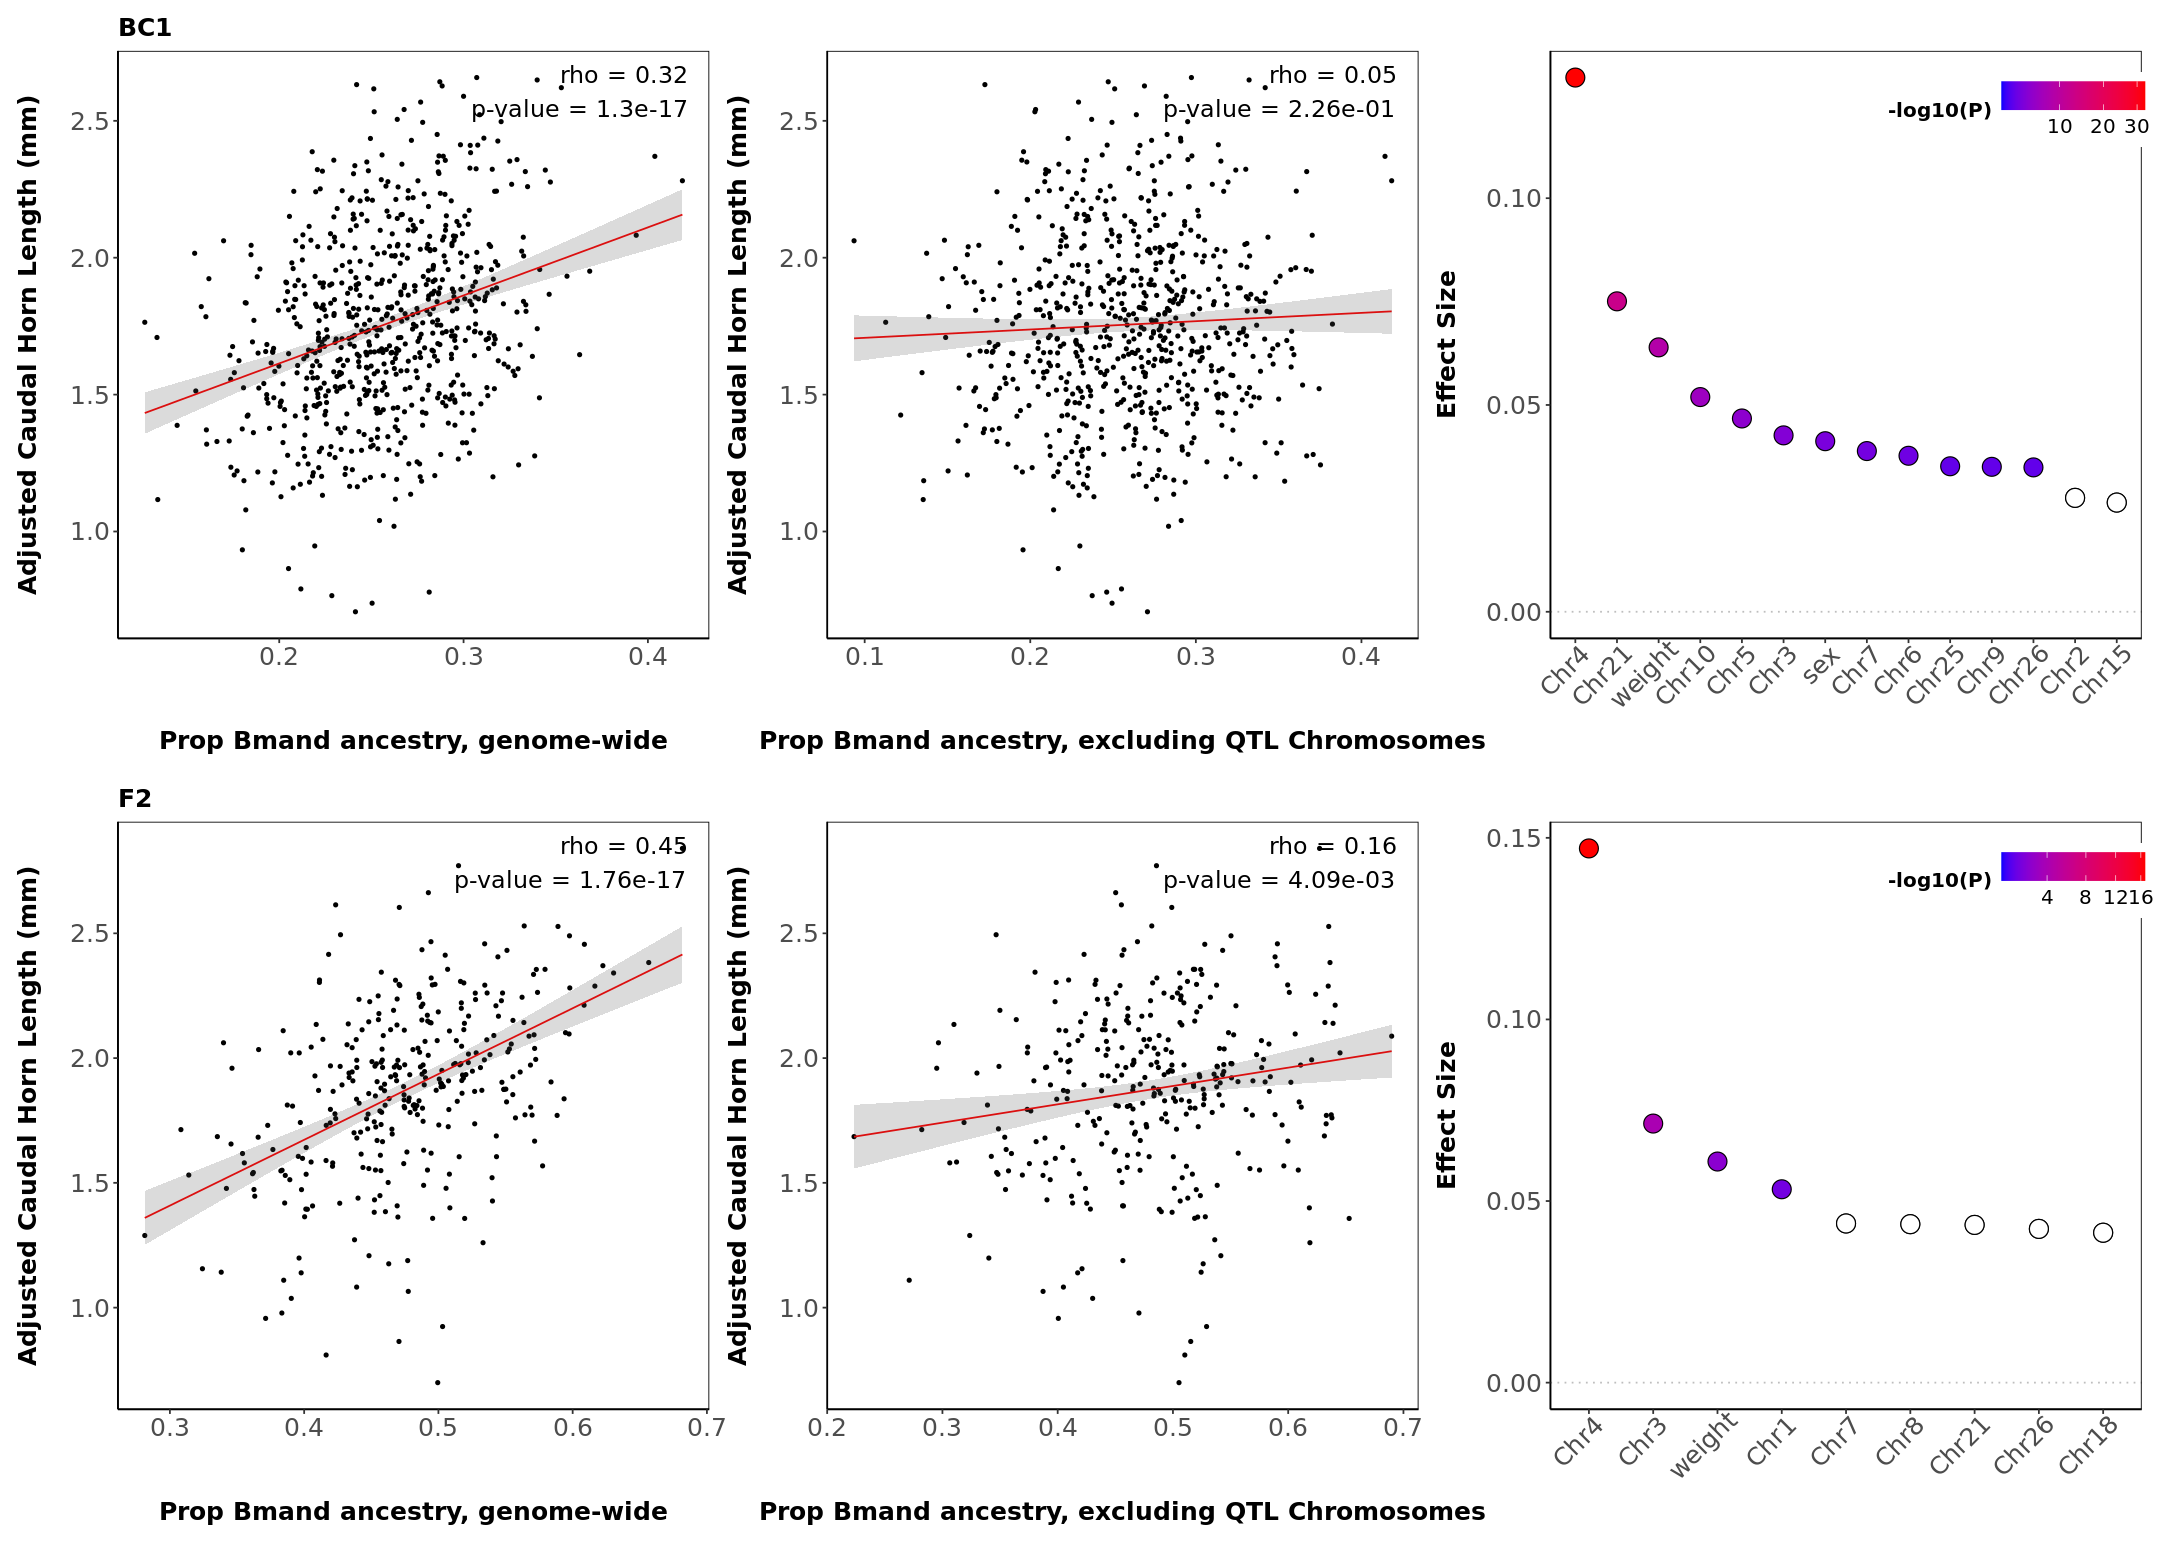

In [158]:
layout_design <- "
    AACCBB
    DDFFEE
"

options(repr.plot.width=18, repr.plot.height=13)

print(BC_length_allchrom + BC_effect_plot + BC_length +
      F2_length_all + F2_effect_plot+ F2_length + 
  plot_layout(design = layout_design))

In [240]:
#pdf("Sfig5_consolidated_v3_weight_covar_v4.pdf", height=13, width=18, useDingbats = FALSE)

#print(BC_length_allchrom + BC_effect_plot + BC_length +
#      F2_length_all + F2_effect_plot+ F2_length + 
#  plot_layout(design = layout_design))
#dev.off()

pdf 
  2